# Proyecto 03 - Series de Tiempo- Martin Iglesias

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa).Se utilizan los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante: Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.**







# Parte A - Exploración de datos

In [ ]:
#Se importan las librerías y funciones a usar.
%matplotlib inline
#Librerías para realizar operaciones con los datos (numpy), fechas (datetime), modelos estadisticos para Series de tiempo (statsmodels) y DataFrames(pandas)
import numpy as np
import pandas as pd
from scipy import stats
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from math import sqrt
import itertools


#Librerías de visualización de datos (matplotlib y Seaborn).
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

#Importo libreria de Machine learning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost #en caso de no tenerlo instalado !pip install xgboost
from xgboost import XGBRegressor 
from xgboost import XGBRFRegressor

#Metricas de evaluacion
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,median_absolute_error




#Extras
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")


#Funciones extras


def RMSE(preds,y):
    """
    Función que realiza el error cuadratico medio de mi valor predicho vs el error verdad. redondeado a 4 decimales
    """
    RMSE=round(np.sqrt(mean_squared_error(preds,y)),3)
    return RMSE
    
#MAPE, es el MAE expresado en terminos porcentuales. Es una métrica con mejor interpretabilidad
from sklearn.utils.validation import check_array as check_arrays
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False,nombreguardado='A'):

    """
    Del artículo https://dzone.com/articles/anomaly-detection-identify-when-currency-crashed
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="best loc", fontsize=10)
    plt.grid(True)
    plt.savefig(path+nombreguardado+'+anomaly',facecolor='xkcd:white')


def plotSerie(serieoriginal,N_train,N_test,look_backm, length_total,y_train_pred,y_test_pred,strmodel):
  ax=plt.figure(figsize=(8,4))
  plt.plot(serieoriginal.index[:length_total], serieoriginal[:length_total],c='k',alpha=0.8,lw = 0.75, label = 'Serie Original')
 # plt.plot(serieoriginal.index[:N_train + look_back], serieoriginal[:N_train + look_back],'--', label = 'Usado para entrenar')
  plt.plot(serieoriginal.index[look_back:  N_train], y_train_pred,'-.',c='r',)#label = 'Predicho en Train')
  plt.plot(serieoriginal.index[N_train: length_total], y_test_pred,'-.', lw = 2,c='g', label = 'Predicho en Test')
  plt.legend(loc='best', fontsize=8)
  plt.xticks(rotation=30)
  plt.xlim(serieoriginal.index[N_train], serieoriginal.index[length_total])
  ax.text(0, 1, r'Modelo:'+strmodel, fontsize=15)
  plt.xlabel('Dia')
  plt.ylabel('cantidad de vehiculos por dia')
  plt.title('Predicción (One Step Prediction) ') 
  plt.savefig(path+'plotSerie'+strmodel,facecolor='xkcd:white')


def MetricasSerie(y_train,y_test,y_train_pred,y_test_pred,modelo):
  #metricas de evaluación en TRAIN y TEST 
    if modelo=='Benchmark':
     MAE_test=mean_absolute_error(y_test, y_test_pred)
     #MAPE_test=mean_absolute_percentage_error(y_test, y_test_pred)
     MedAE_test=median_absolute_error(y_test, y_test_pred)
     MSE_test=mean_squared_error(y_test, y_test_pred)
     RMSE_test=np.sqrt(mean_squared_error(y_test, y_test_pred))
     R2_test=r2_score(y_test, y_test_pred)
     #SCORES=[modelo,np.nan,MAE_test,np.nan,MAPE_test,np.nan,MedAE_test,np.nan,MSE_test,np.nan,RMSE_test,np.nan,R2_test]
     SCORES=[modelo,np.nan,MAE_test,np.nan,MedAE_test,np.nan,MSE_test,np.nan,RMSE_test,np.nan,R2_test]

    else:
     MAE_train=mean_absolute_error(y_train, y_train_pred)
     MAE_test=mean_absolute_error(y_test, y_test_pred)
     #MAPE_train=mean_absolute_percentage_error(y_train, y_train_pred)     
     #MAPE_test=mean_absolute_percentage_error(y_test, y_test_pred)
     MedAE_train=median_absolute_error(y_train, y_train_pred)
     MedAE_test=median_absolute_error(y_test, y_test_pred)
     MSE_train=mean_squared_error(y_train, y_train_pred)
     MSE_test=mean_squared_error(y_test, y_test_pred)
     RMSE_train=np.sqrt(mean_squared_error(y_train, y_train_pred))
     RMSE_test=np.sqrt(mean_squared_error(y_test, y_test_pred))
     R2_train=r2_score(y_train, y_train_pred)
     R2_test=r2_score(y_test, y_test_pred)
     #SCORES=[modelo,MAE_train,MAE_test,MAPE_train,MAPE_test,MedAE_train,MedAE_test,MSE_train,MSE_test,RMSE_train,RMSE_test,R2_train,R2_test]
     SCORES=[modelo,MAE_train,MAE_test,MedAE_train,MedAE_test,MSE_train,MSE_test,RMSE_train,RMSE_test,R2_train,R2_test]
     
    return SCORES


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
def evaluar_model(model, X_train, X_test, y_train, y_test,modelo_a_evaluar='A'):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #RMSE en TRAIN y TEST 
    print('Error RMSE en datos de train:',round(np.sqrt(mean_squared_error(y_train, y_train_pred)),4))
    print('Error RMSE en datos de test:',round(np.sqrt(mean_squared_error(y_test, y_test_pred)),4))
    #R2 en TRAIN y TEST
    print('Error (R2) en datos de train:',round(r2_score(y_train, y_train_pred),5)) 
    print('Error (R2) en datos de test:',round(r2_score(y_test, y_test_pred),5))


    ### GRAFICAMOS la de dispersión de y_test vs y_predic_test y el histograma de distribución de errores(generados por el modelo a partir de los datos dev)
    #Si el modelo de regresión es bueno, cerca de que curva deberían estar los puntos. indicando un buen ajuste.
    fig=plt.figure(figsize = (8,4))
    ax = plt.subplot(1,1,1)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    fig.patch.set_facecolor('xkcd:white')

    plt.tight_layout()
    plt.savefig(path+'YpredvsYreal'+modelo_a_evaluar,facecolor='xkcd:white')
    plt.show()


def timeseriestraintest(serie,look_back,N_train,N_test):
  look_back= look_back #definio cuántos valores *hacia atrás* tomaremos.
  #Creamos los `X` e `y` con ceros para luego llenar con los datos. X e y serán sobre los mismos datos sólo que particiono la serie apartir del look back.
  N = serie.shape[0]
  X = np.zeros((N - look_back - 1,look_back))
  y = np.zeros(N - look_back - 1)
  #print(X.shape, y.shape)
  
  #One-Step Prediction
  #llenamos los datos desde el principio hasta el look back, e y es el dato siguiente al del lookback).
  for i in range(X.shape[0]):
      X[i,:] = serie.iloc[i:i+look_back]
      y[i] = serie.iloc[i+look_back]
  
  N_train = N_train- look_back # cantidad de instancias que vamos a usar para entrenar. 
  N_test = N_test #cantidad de puntos que vamos a usar para evaluar
  N_total = N_train + N_test
  length_total= N_train + N_test + look_back
  
  X_train = X[:N_train,:]
  y_train = y[:N_train]
  #print(X_train.shape, y_train.shape)

  X_test = X[N_train:N_train+N_test,:]# (del final del train para adelante)
  y_test = y[N_train:N_train+N_test]
  #print(X_test.shape, y_test.shape)
  print('Observations: %d' % (len(serie)))
  print('Training Observations: %d' % (len(X_train)))
  print('Testing Observations: %d' % (len(X_test)))
  return length_total,X_train,y_train,X_test,y_test,y






/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


### Preparación del Dataset


In [ ]:
path='/content/drive/MyDrive/Colab Notebooks/B3/Proy3/'
#leemos los datos
data_2019 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto3/Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto3/Datasets/flujo-vehicular-2018.csv', sep =',')

In [ ]:
#reviso la información del dataset
#observo si tiene variables nulas y el tipo de elementos en cada atributo
data_2019.info()
data_2019.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  ...  tipo_vehiculo  forma_pago cantidad_pasos
0     2019  2019-01-01            0  ...        Liviano  NO COBRADO             22
1     2019  2019-01-01            0  ...        Liviano    TELEPASE              6
2     2019  2019-01-01            0  ...        Liviano  NO COBRADO             53
3     2019  2019-01-01            0  ...        Liviano    TELEPASE             18
4     2019  2019-01-01            0  ...        Liviano    EFECTIVO             16

[5 rows x 10 columns]

In [ ]:
data_2018.info() 
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  ...  tipo_vehiculo  forma_pago cantidad_pasos
0     2018  2018-01-01            0  ...        Liviano  NO COBRADO             29
1     2018  2018-01-01            0  ...        Liviano    TELEPASE              9
2     2018  2018-01-01            1  ...        Liviano  NO COBRADO             73
3     2018  2018-01-01            1  ...        Liviano    TELEPASE             39
4     2018  2018-01-01            2  ...        Liviano  NO COBRADO            115

[5 rows x 10 columns]

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [ ]:
#observo los elementos que tienen los atributos 
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())


['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [ ]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())


['Centro' 'Provincia']
['Centro' 'Provincia']


In [ ]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())


['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [ ]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())


['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']


##### Podemos decir entonces que los años 2018 y 2019 tienen las siguientes columnas con la siguiente información:

    periodo: año del dset 
    fecha: año dia mes
    hora_inicio: hora de inicio de la cuenta de vehiculos
    hora_fin:hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora
    dia: dia de la semana 
    estacion: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)
    sentido: Centro o Provincia
    tipo_vehiculo: Liviano o Pesado
    forma_pago: Hay varias y varian entre los años.
    cantidad_pasos: Cantidad de vehiculos por hora

Se trabajará con la estación **Illia** y la forma de pago **Efectivo**

In [ ]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018]) # concatena por fila y tendré un dataset que irá del 2017 al 2020


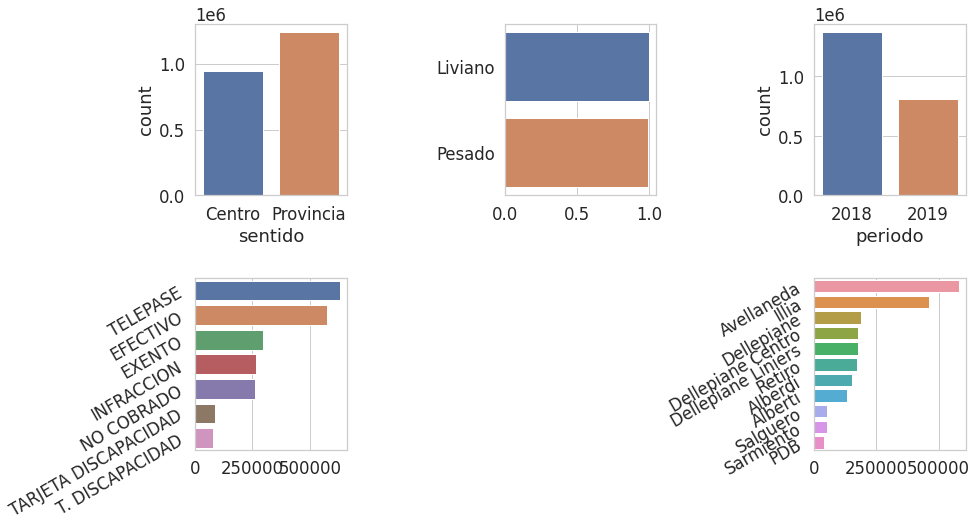

In [ ]:
#observo el dataset en general para indagar sus datos
plt.figure(figsize=(14,10))
plt.subplot(3,3,1)
sns.countplot(data = dataset, x = 'sentido')
plt.subplot(3,3,2)
a=(((dataset['tipo_vehiculo'].sort_values(ascending=True))).value_counts(ascending=False))
a=a/a.max()
sns.barplot(x=a.values, y = a.index)
plt.subplot(3,3,3)
sns.countplot(data = dataset, x = 'periodo')
plt.subplot(3,3,4)
a=(((dataset['forma_pago'].sort_values(ascending=True))).value_counts(ascending=False))
sns.barplot(x=a.values, y = a.index)
plt.yticks(rotation=30)

plt.subplot(3,3,6)
a=(((dataset['estacion'].sort_values(ascending=True))).value_counts(ascending=False))
sns.barplot(x=a.values, y = a.index)
plt.yticks(rotation=30)
plt.tight_layout()


In [ ]:

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [ ]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

Observando las variables que contiene el dataset podemos obtener información general del dataset como que para el período 2018-2019 el flujo vehicular total fue mayor hacia provincia que hacia la capital. 
El mayor flujo vehicular se dio en el 2019 y decreció hacia el 2019. 
Los mayores medios de pagos se dieron con Telepase y Efectivo, mientras que los menores medios de pago se dieron por pagos por discapacidad.
Por último la autopista illia fue la segunda en recibir un caudal importante de automóviles en dicho período.
No hay una distincion entre vehículos pesados y livianos que destaque.

In [ ]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset.head(5)

dia    sentido tipo_vehiculo  cantidad_pasos      fecha
0  Lunes     Centro       Liviano              14 2018-01-01
1  Lunes  Provincia        Pesado               2 2018-01-01
2  Lunes  Provincia        Pesado               3 2018-01-01
3  Lunes  Provincia        Pesado               8 2018-01-01
4  Lunes  Provincia        Pesado               1 2018-01-01

#Exploración de datos
En esta sección se analizarán distintas cuestiones de la serie temporal.

    1°¿qué patrones son llamativos en la serie original y porqué?
    2°¿existem diferencias entre el flujo hacia Capital Federal o hacia Provincia de Buenos Aires?
    3°¿existen días, semanas, meses o trimestres con mayor o menor flujo vehicular? ¿tiene alguna explicación?


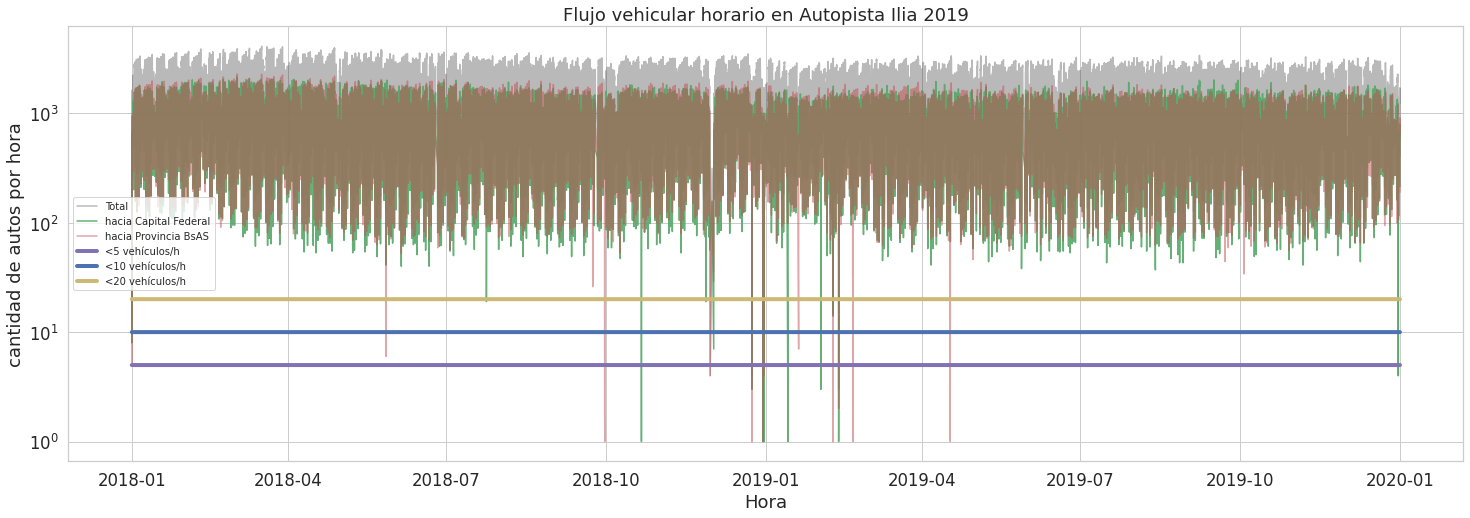

In [ ]:
#Separo el flujo hacia Capital Federal y hacia Provincia de Buenos Aires.
dataset_H = dataset.set_index('fecha')
dataset_H_CF= dataset_H[dataset_H.sentido=='Centro']
dataset_H_Prov=dataset_H[dataset_H.sentido=='Provincia']

#organizo los datos según el flujo de vehículos por hora ordenados por fecha
dataset_H =dataset_H.groupby(by='fecha')['cantidad_pasos'].sum()
dataset_H_CF=dataset_H_CF.groupby(by='fecha')['cantidad_pasos'].sum()
dataset_H_Prov=dataset_H_Prov.groupby(by='fecha')['cantidad_pasos'].sum()


#Grafico las series de tiempo.
fig, ax = plt.subplots(figsize=(25, 8))
# Add x-axis and y-axis
ax.plot(dataset_H.index.values,
           dataset_H.values,
           color='k', alpha=0.3, label='Total')

ax.plot(dataset_H_CF.index.values,
           dataset_H_CF.values,
           color='g', label='hacia Capital Federal', alpha=0.9)

ax.plot(dataset_H_Prov.index.values,
           dataset_H_Prov.values,
           color='r',  label='hacia Provincia BsAS', alpha=0.5)

ax.plot(dataset_H_Prov.index.values,np.full((len(dataset_H_Prov), 1),fill_value=5), color='m', linewidth=4, label='<5 vehículos/h')
ax.plot(dataset_H_Prov.index.values,np.full((len(dataset_H_Prov), 1),fill_value=10), color='b', linewidth=4, label='<10 vehículos/h')
ax.plot(dataset_H_Prov.index.values,np.full((len(dataset_H_Prov), 1),fill_value=20), color='y', linewidth=4, label='<20 vehículos/h')
# Set title and labels for axes
ax.set(xlabel="Hora",
       ylabel="cantidad de autos por hora",
       title="Flujo vehicular horario en Autopista Ilia 2019")
plt.legend(loc='best', fontsize=10)

plt.yscale('log')
plt.savefig(path+'seriehoraria',facecolor='xkcd:white')
plt.show()


 Se observan patrones de la serie que tienen una caida del flujo vehicular hacia ordenes menores al que regular mente presentan (entre 10e2 y 10e3).

En principio observemos a qué se deben los flujos vehiculares que son cero o muy cercanos a cero, viendo si en es en ambos sentidos de circulación o uno. 
Luego se observa, si es posible, qué afectó un sentido de circulación en un dado momento.

In [ ]:
#Observo para ambos sentidos y veo si hay algún día que comparten ambos
Fechas_out_total=dataset_H.index[dataset_H.values<5]
print('En ambos sentidos: ',Fechas_out_total)

Fechas_out_CF=dataset_H_CF.index[dataset_H_CF.values<5]
print('En sentido a CF: ',Fechas_out_CF)

Fechas_out_Prov=dataset_H_Prov.index[dataset_H_Prov.values<5]
print('En sentidos a Prov.BSAS: ',Fechas_out_Prov)



En ambos sentidos:  DatetimeIndex(['2018-11-29 22:00:00', '2018-12-24 00:00:00',
               '2018-12-30 09:00:00', '2018-12-30 11:00:00',
               '2019-02-11 21:00:00', '2019-12-31 00:00:00'],
              dtype='datetime64[ns]', name='fecha', freq=None)
En sentido a CF:  DatetimeIndex(['2018-10-21 08:00:00', '2018-10-21 09:00:00',
               '2018-12-24 00:00:00', '2018-12-30 09:00:00',
               '2018-12-30 11:00:00', '2018-12-31 00:00:00',
               '2019-01-13 17:00:00', '2019-02-01 15:00:00',
               '2019-02-11 21:00:00', '2019-12-31 00:00:00'],
              dtype='datetime64[ns]', name='fecha', freq=None)
En sentidos a Prov.BSAS:  DatetimeIndex(['2018-09-30 04:00:00', '2018-09-30 06:00:00',
               '2018-11-29 22:00:00', '2018-12-24 00:00:00',
               '2018-12-30 11:00:00', '2018-12-31 00:00:00',
               '2019-02-08 16:00:00', '2019-02-11 21:00:00',
               '2019-02-20 03:00:00', '2019-04-17 02:00:00'],
              

**En ambos sentidos vehiculares:** las fechas donde caen a menos de 5-10 vehículos por hora son:
   '2018-11-29 22:00:00' [G20](https://twitter.com/batransito/status/1067889371175690251?lang=es) [G20 2](https://twitter.com/alertastransito/status/1068089081266126848)

  '2018-12-24 00:00:00'  [Feriado Navidad](#https://www.clarin.com/sociedad/24-diciembre-feriado_0_5zO3o6DfmZ.html) [Feriado Navidad 2](https://www.revistacolectibondi.com.ar/2018/12/24/como-funcionara-el-transporte-publico-este-24-y-25-de-diciembre/)

   '2018-12-30 11:00:00', '2018-12-30 11:00:00' y '2019-12-31 00:00:00' Posiblemente se deba a visperas de Año Nuevo.

   '2019-02-11 21:00:00'  [Protestas de organizaciones sociales](https://www.perfil.com/noticias/actualidad/cuales-son-cortes-complicaran-transito-ciudad-buenos-aires.phtml)


**En sentido a Capital Federal:** las fechas donde caen a menos de 5-10 vehículos por hora son:

'2018-12-24 00:00:00', '2018-12-30 09:00:00', '2018-12-30 11:00:00', '2018-12-31 00:00:00' y '2019-12-31 00:00:00': Posiblemente se deba a visperas de navidad y de Año Nuevo.

'2019-05-29' https://www.clarin.com/politica/paro-29-piquetes-complicaran-transito_0_VGp5_EaAo.html



Este dato es llamativo ya que se generó el recambio turístico, es posible que esta caida del transporte se deba a un embotellamiento en la autopista: '2019-02-01 15:00:00' [texto del enlace](https://www.clarin.com/sociedad/recambio-febrero-junto-fin-semana-cargaron-rutas_0_2JCK2Yudv.html)

Unknown:  '2018-10-21 08:00:00' , '2018-10-21 09:00:00' , '2019-01-13 17:00:00' 

**En sentido a Provincia de Buenos Aires:** las fechas donde caen a menos de 5-10 vehículos por hora son:

'2018-11-29 22:00:00' [G20](https://www.telam.com.ar/notas/201811/307908-g20-transito-cortes-servicios-publicos.html)

'2018-12-24 00:00:00', '2018-12-30 11:00:00' y'2018-12-31 00:00:00':  Posiblemente se deba a visperas de navidad y de Año Nuevo.

Unknown:  '2018-09-30 04:00:00', '2018-09-30 06:00:00', '2019-02-08 16:00:00', '2019-02-11 21:00:00', '2019-02-20 03:00:00' y '2019-04-17 02:00:00'

#Visualización de períodos: Diario, semanal y mensual.

¿existen días, semanas, meses o trimestres con mayor o menor flujo vehicular? ¿tiene alguna explicación?


In [ ]:
#obs:se aclara que el flujo vehicular total es equivalente al flujo vehicular hacia capital más el que va hacia provincia.
# Resampleo diario, semanal y mensual del flujo vehicular
dataset_D = dataset.resample('D', on='fecha').sum() #diario
dataset_M = dataset.resample('M', on = 'fecha').sum() #mensual
dataset_T = dataset.resample('Q', on = 'fecha').sum()#trimestral (estaciones)
#Separo el flujo hacia Capital Federal y hacia Provincia de Buenos Aires.
Datos_CF_H= dataset[dataset.sentido=='Centro']
Datos_Prov_H= dataset[dataset.sentido=='Provincia']

Datos_CF_D = Datos_CF_H.resample('D', on='fecha').sum()
Datos_CF_M = Datos_CF_H.resample('M', on = 'fecha').sum()
Datos_CF_T = Datos_CF_H.resample('Q', on = 'fecha').sum()

Datos_Prov_D = Datos_Prov_H.resample('D', on='fecha').sum()
Datos_Prov_M = Datos_Prov_H.resample('M', on = 'fecha').sum()
Datos_Prov_T = Datos_Prov_H.resample('Q', on = 'fecha').sum()

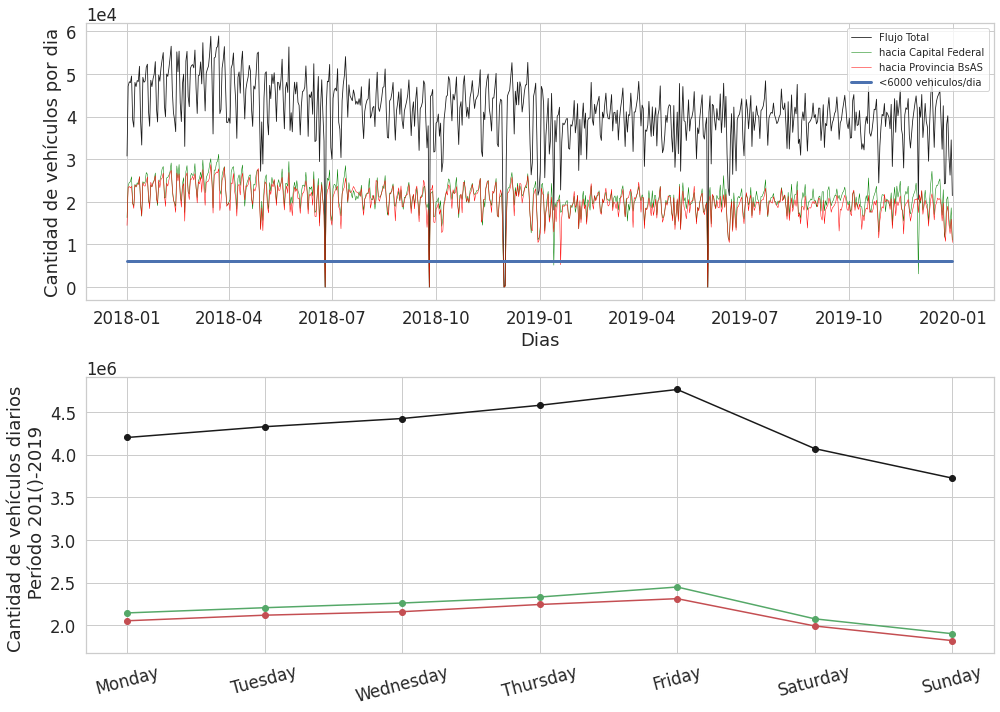

En ambos sentidos:  fecha
2018-06-25    0
2018-09-25    0
2018-11-30    0
2019-05-29    0
Name: cantidad_pasos, dtype: int64
Sentido Capital Federal:  fecha
2018-06-25       0
2018-09-25       0
2018-11-30       0
2018-12-01     164
2019-01-13    5135
2019-05-29       0
2019-12-01    3085
Name: cantidad_pasos, dtype: int64
Sentido Provincia BSAS:  fecha
2018-06-25       0
2018-09-25       0
2018-11-30       0
2018-12-01     186
2019-01-19    5237
2019-05-29       0
Name: cantidad_pasos, dtype: int64


In [ ]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset_D
diario['dias'] = diario.index.day_name()

diario_CF =Datos_CF_D
diario_CF['dias'] = diario_CF.index.day_name()

diario_Prov =Datos_Prov_D
diario_Prov['dias'] = diario_Prov.index.day_name()

#otra forma de agreg los días, string, para ubicarlos en el calendario
#diario['dias']=str(np.zeros((diario.shape)))
#dia=['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado','Domingo']
#j=0
#for i in range(0,len(diario.index)):
#  diario.dias[i]=dia[j]
#  j+=1
#  if j==7:
#    j=0

#cambio los días de manera ordenada y los agrupo
df_mapping = pd.DataFrame({'order': ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']})
sort_mapping = df_mapping.reset_index().set_index('order')



diario['Dia_semana'] = diario['dias'].map(sort_mapping['index'])
diario=diario.groupby(by='dias').sum()
diario=diario.sort_values('Dia_semana')

diario_CF['Dia_semana'] = diario_CF['dias'].map(sort_mapping['index'])
diario_CF=diario_CF.groupby(by='dias').sum()
diario_CF=diario_CF.sort_values('Dia_semana')

diario_Prov['Dia_semana'] = diario_Prov['dias'].map(sort_mapping['index'])
diario_Prov=diario_Prov.groupby(by='dias').sum()
diario_Prov=diario_Prov.sort_values('Dia_semana')



#Visualizamos los datos de la serie de tiempo para observar si existen datos que llamen la atención o algun parámetro
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
plt.plot(dataset_D.index,dataset_D.cantidad_pasos,linewidth=0.8,c='k', label='Flujo Total')
#plt.scatter(dataset_D.index,dataset_D.cantidad_pasos)
plt.plot(Datos_CF_D.index.values,Datos_CF_D.cantidad_pasos,linewidth=0.5, linestyle='-',c='green', label='hacia Capital Federal')
plt.plot(Datos_Prov_D.index.values,Datos_Prov_D.cantidad_pasos,linewidth=0.5, linestyle='-',c='red', label='hacia Provincia BsAS')
plt.plot(dataset_D.index.values,np.full((len(dataset_D), 1),fill_value=6000), color='b', linewidth=3, label='<6000 vehiculos/dia')
plt.xlabel('Dias')
plt.ylabel('Cantidad de vehículos por dia')
plt.legend(loc='best',fontsize=10)

plt.ticklabel_format(style='sci', axis='y', useOffset=True, scilimits=(0,0))

plt.subplot(2,1,2)
plt.plot(diario.index, diario.cantidad_pasos, color='k',marker='o',label='total')
plt.plot(diario_CF.index, diario_CF.cantidad_pasos,color='g',marker='o',label='hacia capital')
plt.plot(diario_Prov.index, diario_Prov.cantidad_pasos,color='r',marker='o',label='hacia provincia')
plt.xticks(rotation=15)
plt.ylabel('Cantidad de vehículos diarios \n Período 201()-2019')
plt.tight_layout()
plt.savefig(path+'seriediariayondadiaria',facecolor='xkcd:white')
plt.show()

#observo los valores que caen a cero vehiculos por dia
Fechas_out_total=dataset_D[dataset_D.cantidad_pasos<5]
print('En ambos sentidos: ',Fechas_out_total.cantidad_pasos)

#observo los valores menores a 10 vehiculos por dia

Fechas_out_total=Datos_CF_D[Datos_CF_D.cantidad_pasos<6000]
print('Sentido Capital Federal: ',Fechas_out_total.cantidad_pasos)
Fechas_out_total=Datos_Prov_D[Datos_Prov_D.cantidad_pasos<6000]
print('Sentido Provincia BSAS: ',Fechas_out_total.cantidad_pasos)


**Grafico 1:**La evolución diaria del flujo vehicular muestra que durante el período 2018, un incremento el primer trimestre y luego un descenso hasta ordenes de 4e4. Para la segunda mitad del año se observa más variabilidad de la serie debido a los días donde el flujo vehicular se desploma a cero y su restitución lenta en los días siguientes.
Estos días corresponden a:

2018-06-25   [Paro sindical](https://elpais.com/internacional/2018/06/25/argentina/1529921664_282510.html)       
2018-09-25   Unknown

2018-11-30   [G20](https://www.consilium.europa.eu/es/meetings/international-summit/2018/11/30-01/)

2019-05-29  [Huelga General]( https://www.dw.com/es/argentina-gobierno-enfrenta-una-nueva-huelga-general/a-48973717)

Respecto al flujo en alguno de los dos sentidos, se observan algunos días con valores llamativos menores a 5000 vehiculos por dia. Se desconoce la causa, posiblemente afectados por alguna huelga, corte vehicular o desvío por obras (en esos momentos la construcción del pasaje del Bajo se encontraba en actividad).

Para el año 2019 se ve una variabilidad menor con una tendencia más constante sin aumentos ni disminución grande.


**Grafico2**: Observamos que sobre la autopista Illia para el período total de estudio que el flujo vehicular se va incrementando durante los dias de la semana y alcanza su máximo el Viernes, tanto el flujo hacia Capital o Provincia de Buenos Aires. Durante el fin de semana decae fuertemente.

Observacion:
Un análisis similar se hizo para el resampleo semanal y no se encontraron elementos particulares. Las conclusiones son similares a las que se observaron en la evolución diaria.

            cantidad_pasos       mes  mensual
fecha                                        
2019-02-28         1103086  February      1.0


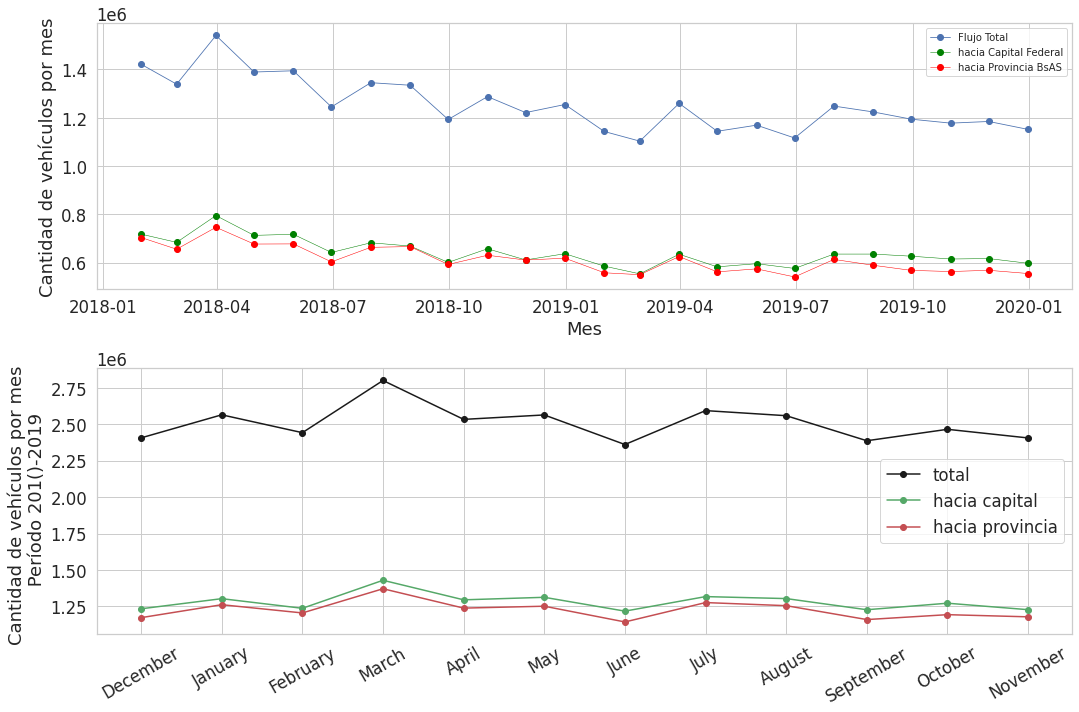

In [ ]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
mensual = dataset_M
mensual['mes'] = mensual.index.month_name()

mensual_CF =Datos_CF_D
mensual_CF['mes'] = mensual_CF.index.month_name()

mensual_Prov =Datos_Prov_D
mensual_Prov['mes'] = mensual_Prov.index.month_name()


#cambio los días de manera ordenada y los agrupo
df_mapping = pd.DataFrame({'order': ['January','February','March','April','May','June','July','August','September','October','November','Dicember']})
sort_mapping = df_mapping.reset_index().set_index('order')

mensual['mensual'] = mensual['mes'].map(sort_mapping['index'])
mensual=mensual.groupby(by='mes').sum()
mensual=mensual.sort_values('mensual')

mensual_CF['mensual'] = mensual_CF['mes'].map(sort_mapping['index'])
mensual_CF=mensual_CF.groupby(by='mes').sum()
mensual_CF=mensual_CF.sort_values('mensual')

mensual_Prov['mensual'] = mensual_Prov['mes'].map(sort_mapping['index'])
mensual_Prov=mensual_Prov.groupby(by='mes').sum()
mensual_Prov=mensual_Prov.sort_values('mensual')



plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
#Visualizamos los datos de la serie de tiempo para observar si existen datos que llamen la atención o algun parámetro

plt.plot(dataset_M.index,dataset_M.cantidad_pasos,linewidth=0.8, label='Flujo Total',marker='o')
plt.plot(Datos_CF_M.index.values,Datos_CF_M.cantidad_pasos,linewidth=0.5, linestyle='-',c='green',marker='o', label='hacia Capital Federal')
plt.plot(Datos_Prov_M.index.values,Datos_Prov_M.cantidad_pasos,linewidth=0.5, linestyle='-',c='red',marker='o', label='hacia Provincia BsAS')
plt.legend(loc='best')

plt.xlabel('Mes')
plt.ylabel('Cantidad de vehículos por mes')
plt.legend(fontsize=10)

plt.ticklabel_format(style='sci', axis='y', useOffset=True, scilimits=(0,0))

plt.subplot(2,1,2)
#Resampleamos nuestros datos para agrupar por mes, y asi tal vez lograr una visualización mas amigable
plt.plot(mensual.index, mensual.cantidad_pasos, color='k',marker='o',label='total')
plt.plot(mensual_CF.index, mensual_CF.cantidad_pasos,color='g',marker='o',label='hacia capital')
plt.plot(mensual_Prov.index, mensual_Prov.cantidad_pasos,color='r',marker='o',label='hacia provincia')
plt.legend(loc='best')
plt.xticks(rotation=30)
plt.ylabel('Cantidad de vehículos por mes \n Período 201()-2019')
plt.tight_layout()
plt.savefig(path+'seriemensual+ondamensual',facecolor='xkcd:white')

#el mes con el mínimo trafico vehicular es Febrero del 2019
Fechas_out_total=dataset_M[dataset_M.cantidad_pasos<1105000]
print(Fechas_out_total)

Analizandoel grafico 1
hacia finales del 2018 hasta entrado el primer trimestre del 2019 se observa que el flujo en ambos sentidosfue muy similar. Sin embargo previo y post ese rango de tiempo el flujo vehicular hacia capital federal aumentó al menos 1e5-2e5 vehículos por mes. En términos generales se ve el mismo decaimiento del flujo vehicular entre 2018 y 2019. Una posible hipotesis es el cambio de la forma de pago (a telepase) ó un aumento de las tarifas del peaje que generaron que la gente pase del transporte propio al público.


Realizando un análisis similar al que se hizo con el transito vehicular por días respecto al período total, en este caso para cada mes. En el gráfico 2 se observa que hacial el final del Verano del Hemisferio Sur (Marzo) el flujo vehicular aumenta considerablemente. Posiblemente se deba la vuelta previa al comienzo de las clases/actividades generales, que surje a posterior del fin del verano turístico.
Un segundo máximo secundario se observa en Julio, esto también puede estar asociado al receso invernal, donde el flujo pudo haberse afectado. Sin embargo, hay que hacer una observación sobre que no se conocen estadísticas sobre qué flujo se considera normal. Aquí se acercan meras suposiciones y se puede ver afectado a los cambios de cada período.

Este flujo vehicular del período total muestra que el 2018 influencia más esta segunda gráfica.

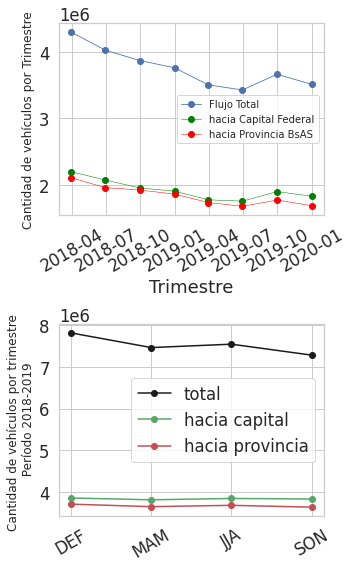

In [ ]:
#Resampleamos nuestros datos para agrupar por trimestre, y asi tal vez lograr una visualización mas amigable
trimestral = dataset_T

#Resampleamos nuestros datos para agrupar por trimestre, y asi tal vez lograr una visualización mas amigable
#forma de agregar trimestre, string, para ubicarlos en el calendario
trimestral['trimestre']=str(np.zeros((trimestral.shape)))
#Diciembre Enero Febrero (DEF) # Marzo Abril Mayo (MAM) # Junio Julio Agosto (JJA) # Septiembre Octubre Noviembre (SON)
tri=['DEF','MAM','JJA','SON']
j=0
for i in range(0,len(trimestral.index)):
  trimestral.trimestre[i]=tri[j]
  j+=1
  if j==4:
    j=0


trimestral_CF =Datos_CF_D
trimestral_CF['trimestre']=str(np.zeros((trimestral_CF.shape)))
tri=['DEF','MAM','JJA','SON']
j=0
for i in range(0,len(trimestral_CF.index)):
  trimestral_CF.trimestre[i]=tri[j]
  j+=1
  if j==4:
    j=0

trimestral_Prov =Datos_Prov_D
trimestral_Prov['trimestre']=str(np.zeros((trimestral_Prov.shape)))
tri=['DEF','MAM','JJA','SON']
j=0
for i in range(0,len(trimestral_Prov.index)):
  trimestral_Prov.trimestre[i]=tri[j]
  j+=1
  if j==4:
    j=0




#cambio los días de manera ordenada y los agrupo
df_mapping = pd.DataFrame({'order': ['DEF','MAM','JJA','SON']})
sort_mapping = df_mapping.reset_index().set_index('order')

trimestral['trimestre'] = trimestral['trimestre'].map(sort_mapping['index'])
trimestral=trimestral.groupby(by='trimestre').sum()
trimestral=trimestral.sort_values('trimestre')
trimestral.index = list(['DEF', 'MAM', 'JJA', 'SON'])

trimestral_CF['trimestre'] = trimestral_CF['trimestre'].map(sort_mapping['index'])
trimestral_CF=trimestral_CF.groupby(by='trimestre').sum()
trimestral_CF=trimestral_CF.sort_values('trimestre')
trimestral_CF.index = list(['DEF', 'MAM', 'JJA', 'SON'])

trimestral_Prov['trimestre'] = trimestral_Prov['trimestre'].map(sort_mapping['index'])
trimestral_Prov=trimestral_Prov.groupby(by='trimestre').sum()
trimestral_Prov=trimestral_Prov.sort_values('trimestre')
trimestral_Prov.index = list(['DEF', 'MAM', 'JJA', 'SON'])



#Visualizamos los datos de la serie de tiempo para observar si existen datos que llamen la atención o algun parámetro
plt.figure(figsize=(5,8))
plt.subplot(2,1,1)
plt.plot(dataset_T.index,dataset_T.cantidad_pasos,linewidth=0.8,marker='o', label='Flujo Total')
plt.plot(Datos_CF_T.index.values,Datos_CF_T.cantidad_pasos,linewidth=0.5, linestyle='-',c='green',marker='o', label='hacia Capital Federal')
plt.plot(Datos_Prov_T.index.values,Datos_Prov_T.cantidad_pasos,linewidth=0.5, linestyle='-',c='red',marker='o', label='hacia Provincia BsAS')
plt.xticks(rotation=30)
plt.xlabel('Trimestre')
plt.ylabel('Cantidad de vehículos por Trimestre',fontsize=12)
plt.legend(loc='best',fontsize=10)
plt.ticklabel_format(style='sci', axis='y', useOffset=True, scilimits=(0,0))


plt.subplot(2,1,2)
#Resampleamos nuestros datos para agrupar por mes, y asi tal vez lograr una visualización mas amigable
plt.plot(trimestral.index, trimestral.cantidad_pasos, color='k',marker='o',label='total')
plt.plot(trimestral_CF.index, trimestral_CF.cantidad_pasos,color='g',marker='o',label='hacia capital')
plt.plot(trimestral_Prov.index, trimestral_Prov.cantidad_pasos,color='r',marker='o',label='hacia provincia')
plt.legend(loc='best')
plt.xticks(rotation=30)
plt.ylabel('Cantidad de vehículos por trimestre \n Período 2018-2019', fontsize=12)
plt.tight_layout()
plt.savefig(path+'serietrimestral+ondatrimestral',facecolor='xkcd:white')


Analizando trimestralmente la serie total, se puede ver a simple vista una tendencia de decaimiento del flujo vehicular de valores de 1e6 aprox en todo el 2018, con una leve recuperación hacia el 2019. 
Por otra parte como veníamos viendo para el período total el trimestre de verano muestra un máximo de flujo vehicular, y un segundodo máximo en JJA y un mínimo en SON.

#Analisis de datos extremos y faltantes

¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. Pista: primer semestre 2019.


La cantidad de datos Faltantes son: 0


Text(69.0, 0.5, 'Cantidad de vehículos por día')

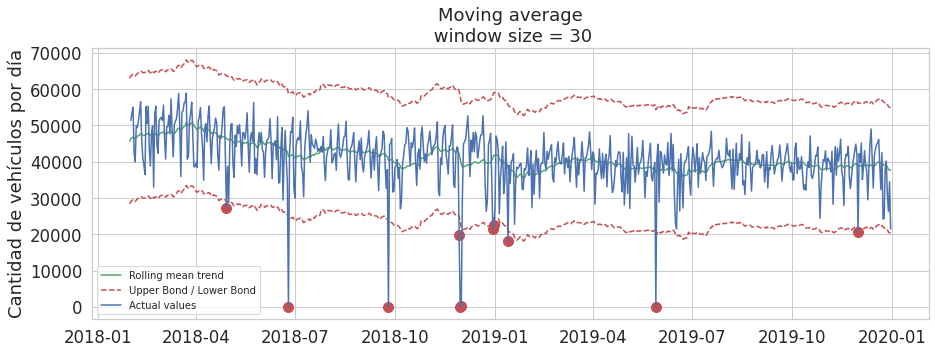

In [ ]:
#Analizo datos faltantes y anomalías
print('La cantidad de datos Faltantes son:', dataset_H.isna().sum())
#En caso de haber datos faltantes una posible forma de completarlo es mediante una interpolación, dependerá de la cantidad de elementos faltantes cómo será la interpolación.
#datos_sinNAN = dataset.interpolate() # interpolo los nans entre los elementos

#Observo datos outliers, lo analizo con la función de que usa la media movil y el std para observar cuánto me separo de la serie, respecto a un dado criterio de significancia.
#se define anomalía o outlier como rolling_mean + (mae + scale * deviation) , con el desvio de la serie menos su media. 
#upper y lower bond son los intervalos de confianza donde los datos son significativosy permite detectar outliers (anomalias)
dataset_D = dataset.resample('D', on='fecha').sum() #diario
plotMovingAverage(dataset_D, 30, plot_intervals=True, scale=1.96, plot_anomalies=True,nombreguardado='seriecompleta')
plt.ylabel('Cantidad de vehículos por día')
#Con el análisis previo los datos otuliers más extremos se deben a huelgas y paros que obstruyeron el flujo de tránsito en la Autopista illia.
#Los outliers que se muestran cerca del rángo de signficiancia se deben a variaciones en el tránsito vehicular en un solo sentido.

# Componentes de la serie

Calcula las componentes estacionales y tendencia de la serie. 

Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).


# Analisis de tendencias

**Ventanas moviles:**
Es un proceso similar al resampleo, con la diferencia es en cómo se eligen las divisiones (bins) en donde se realiza la función de resampleo, ajustado a una ventana temporal y se va poniendo el valor en alguna posición de la ventana (por defecto el centro). Esta técnica que suaviza la serie permite observar la tendencia para distintas rangos de apertura de la ventana.Ej:

    Bins en caso de un resampleo semanal: Jan1- Jan 7; Jan8 - Jan14, Jan 15 - Jan 21, etc
    Bins en caso de una ventana semanal: Jan1- Jan7; Jan 2- Jan 8, Jan 3- Jan 9, etc.



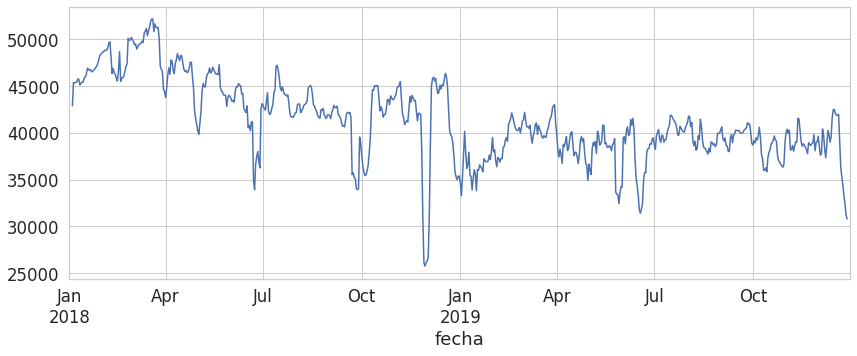

In [ ]:
#ventana semanal
dataset_D_Wind7 = dataset_D['cantidad_pasos'].rolling(window = 7, center = True).mean()
dataset_D_Wind7.plot(figsize=(14,5))


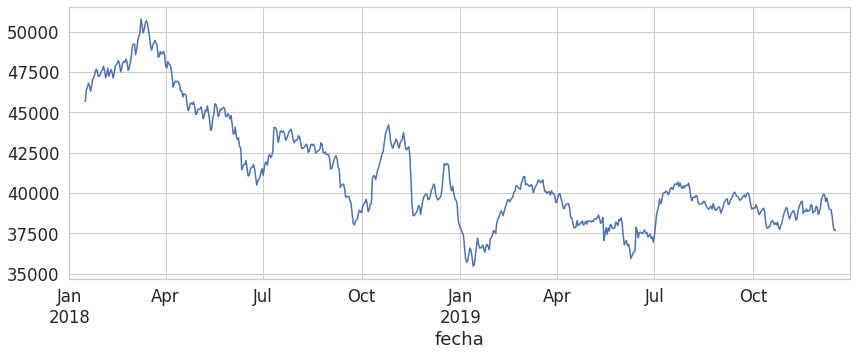

In [ ]:
#ventana mensual
dataset_D_Wind30= dataset_D['cantidad_pasos'].rolling(window = 30, center = True).mean()
dataset_D_Wind30.plot(figsize=(14,5))


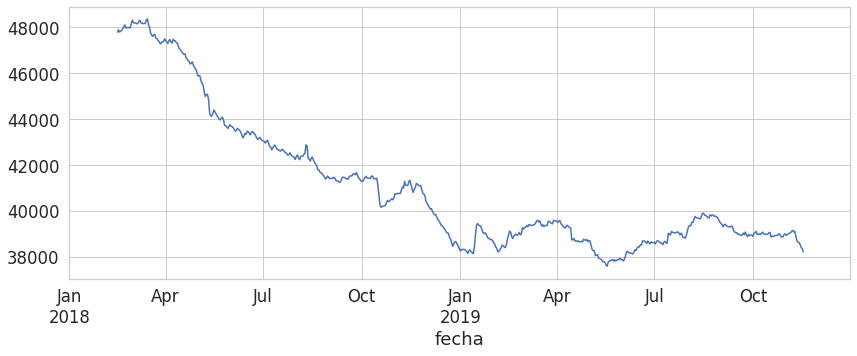

In [ ]:
#ventana Trimestral
dataset_D_Wind90= dataset_D['cantidad_pasos'].rolling(window = 90, center = True).mean()
dataset_D_Wind90.plot(figsize=(14,5))

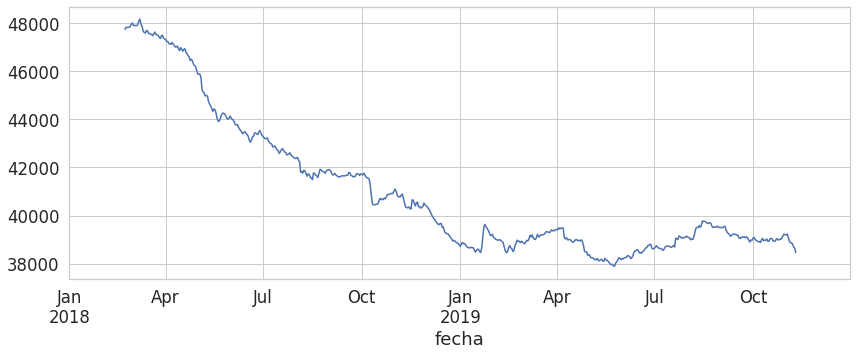

In [ ]:
#ventana bianual
ventana = int(365*2/7)
semanal_promedio_tendencia = dataset_D.cantidad_pasos.rolling(window=ventana, center = True).mean()
semanal_promedio_tendencia.plot(figsize=(14,5))


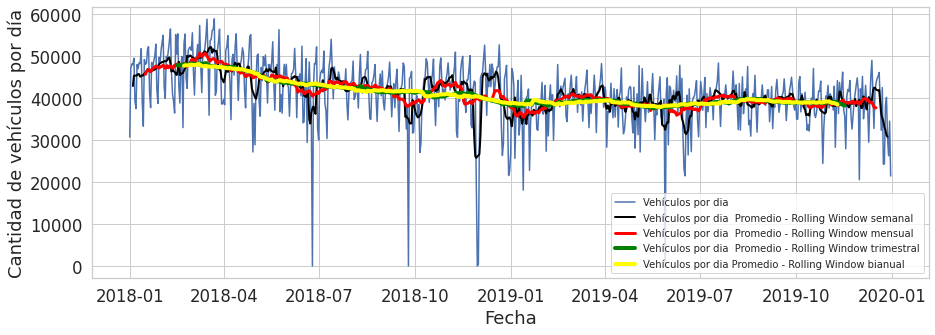

In [ ]:
#lo comparo respecto a la serie original
plt.figure(figsize = (15,5))
plt.plot(dataset_D.index, dataset_D.cantidad_pasos, label = 'Vehículos por dia')
plt.plot(dataset_D_Wind7, lw = 2, color='black', label = 'Vehículos por dia  Promedio - Rolling Window semanal')
plt.plot(dataset_D_Wind30, lw = 3, color='red', label = 'Vehículos por dia  Promedio - Rolling Window mensual')
plt.plot(dataset_D_Wind90, lw = 4, color='green', label = 'Vehículos por dia  Promedio - Rolling Window trimestral')
plt.plot(semanal_promedio_tendencia, lw = 4, color='yellow', label = 'Vehículos por dia Promedio - Rolling Window bianual')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehículos por día')
plt.legend(fontsize=10)
plt.savefig(path+'ventanasmoviles',facecolor='xkcd:white')
plt.show()

Analizando las distintas ventanas se observa que:
Para una ventana bianual se tiene una tendencia negativa entre 2018-2019, sin variabilidad distinguible.
Para una ventana de menor tiempo (trimestral, mensual o semanal) la variabilidad de la serie aún persiste con ciclos.
A continuación se observa con una regresión lineal si la tendencia tiene una evolución lineal.


#Tendencia Lineal

Se ajusta una regresión lineal a la serie. 



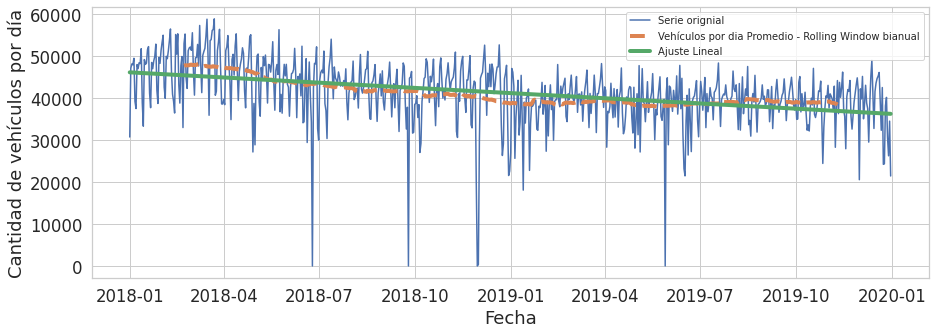

In [ ]:
#Hay que tener en cuenta es que no podemos ajustar una regresión lineal con las fechas así como las tenemos, por lo que tenemos que pasarlas a un formato numérico.
dataset_D['fecha_numeros']=dataset_D.index.map(datetime.datetime.toordinal)
dataset_D.head()
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(dataset_D.fecha_numeros.values.reshape(-1, 1), dataset_D.cantidad_pasos)



plt.figure(figsize = (15,5))
plt.plot(dataset_D.index, dataset_D.cantidad_pasos, label = 'Serie orignial')
plt.plot(semanal_promedio_tendencia, ls = '--', lw = 4, label = 'Vehículos por dia Promedio - Rolling Window bianual')
plt.plot(dataset_D.index, lr.predict(dataset_D.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Ajuste Lineal')
# plt.xlim(datetime.date(1985,1,1), datetime.date(2018,1,1))
# plt.ylim([0,30])
plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehículos por día')
plt.legend(fontsize=10)
plt.savefig(path+'tendencialinealserie',facecolor='xkcd:white')
plt.show()

A comparación del ajuste lineal se tiene que si bien la tendencia es negativa, no presenta la misma tasa de decrecimiento. Esto es debido a la variabilidad de 4 oscilaciones de baja frecuencia en 2 años.

# Estacionalidad y Ruido

(array([736754., 736815., 736876., 736938., 736999., 737060., 737119.,
        737180., 737241., 737303., 737364.]),
 <a list of 11 Text major ticklabel objects>)

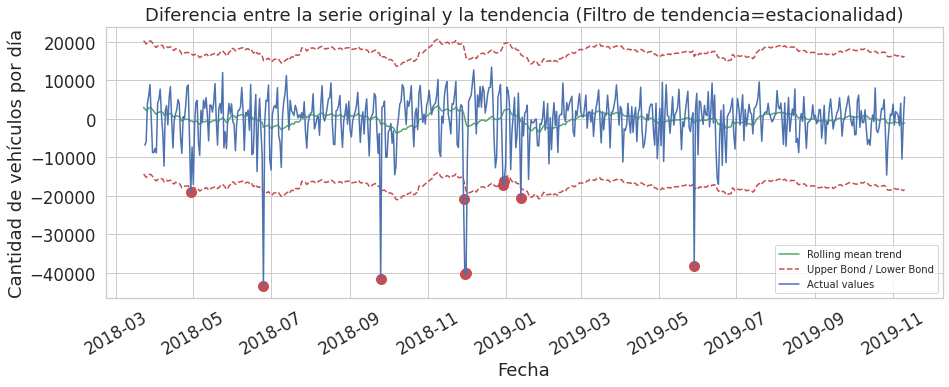

In [ ]:
#Analizo la serie filtrando la tendencia
dataset_D_filtrotend=pd.DataFrame((dataset_D.cantidad_pasos - semanal_promedio_tendencia).dropna())
plotMovingAverage(dataset_D_filtrotend, 30, plot_intervals=True, scale=1.96, plot_anomalies=True,nombreguardado='seriesintendencia')
plt.title('Diferencia entre la serie original y la tendencia (Filtro de tendencia=estacionalidad)')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehículos por día')

plt.xticks(rotation=30)

Al remover la tendencia de la serie se tiene los elementos estacionales más el ruido. Los patrones extremos siguen estando presentes como parte de un cambio en la aleatoriedad o eventos drasticos.

Los datos de las series temporales pueden mostrar una variedad de patrones, y a menudo es útil dividir una serie temporal en varios componentes, cada uno de los cuales representa una categoría de patrón subyacente.



Existen tres tipos de patrones de series temporales: tendencia, estacionalidad y ciclos. Cuando descomponemos una serie temporal la pensamos con una componente de tendencia, un componente estacional y un componente residual (que contiene cualquier otro elemento de la serie temporal).



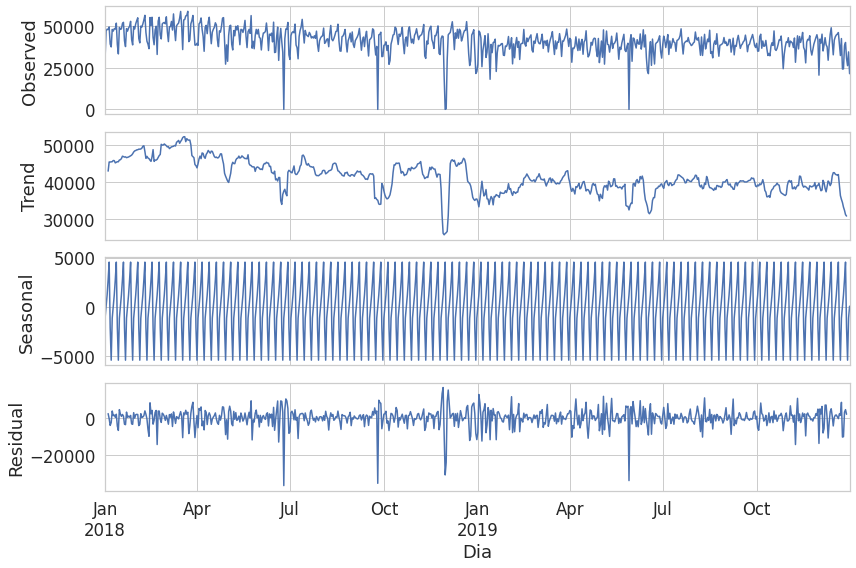

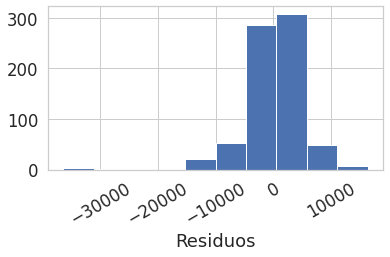

In [ ]:
#Análisis de series temporales para modelos aditivos y multiplicativos
#se descompone a la serie en una componente Tendencial, Estacional y Residual
result_adi = seasonal_decompose(dataset_D.cantidad_pasos, model='additive') #usa un modelo adaptativo por como se estudia la estacionanlidad

import matplotlib
matplotlib.rcParams['figure.figsize'] = [12,8]
result_adi.plot()
plt.xlabel('Dia')
plt.savefig(path+'descomposicionaditivaserie',facecolor='xkcd:white')
plt.show()

#Veo la distribución del residuo
matplotlib.rcParams['figure.figsize'] = [6,3]
result_adi.resid.hist()
plt.xlabel('Residuos')
plt.xticks(rotation=30)
plt.savefig(path+'residuosaditivo',facecolor='xkcd:white')

Observando y comparando la serie anterior (ruido+estacionalidad)se observa que la parte estacional muestra un ciclo cuasi bimensual, con ordenes que muestran que el residuo influencia gran parte de la serie, además de los valores extremos. Un ejemplo de esto se observa en el residuo en las fechas alrededor del comienzo de enero de 2019.
El residuo presenta una asimetría negativa, efecto de los valores extremos que generan un trafico que tiende a cero (cambios bruscos no previstos en la tendencia ni ciclos).

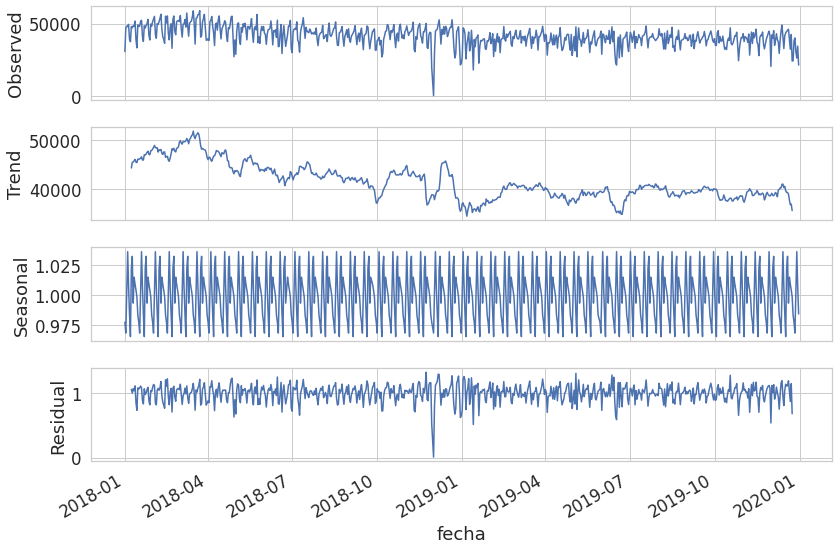

(array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ]),
 <a list of 8 Text major ticklabel objects>)

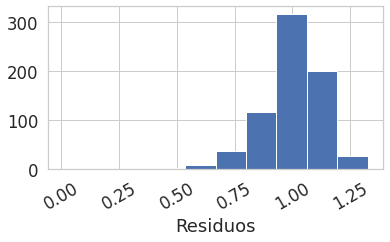

In [ ]:
#obs: se hace una aclaración sobre que la serie original en este caso se toman aquellos cuyos valores sean positivos en cantidad de pasos ya que el método multiplicativo no acepta valores menores o iguales a cero, es por ello que si uno compara con la serie de la descomposición adaptativa se tiene menos valores extremos (que son igual a cero).
M=dataset_D[dataset_D.cantidad_pasos>0]
#se descompone a la serie en una componente Tendencial, Estacional y Residual
result_mul = seasonal_decompose(M.cantidad_pasos, model='multiplicative', freq=15) 
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12,8]
result_mul.plot()
plt.savefig(path+'descomposicionmultiplicativa',facecolor='xkcd:white')
plt.show()

#Veo la distribución del residuo
matplotlib.rcParams['figure.figsize'] = [6,3]
result_mul.resid.hist()
plt.xlabel('Residuos')
plt.savefig(path+'residuosmultiplicativos',facecolor='xkcd:white')
plt.xticks(rotation=30)

Analizando el modelo multiplicativo muestra una tendencia más suavizada, ya que no se observa la influencia de valores extremos como en el modelo aditivo. La componente estacional encuentra un patron de alta frecuencia combinado con uno de baja frecuencia.
En cuanto al residuo se observan menos patrones significativos, mas la frecuencia no disminuye en comparación al modelo aditivo.

# Autocorrelación y Análisis de espectro de poder


ACF es una función de autocorrelación (completa) que nos da valores de autocorrelación de cualquier serie con sus valores previos. Se plotean estos valores junto con la región de confianza. Esto describe lo bien que se relaciona el valor actual de la serie con sus valores pasados. Una serie temporal puede tener componentes como la tendencia, la estacionalidad, la ciclicidad y el residuo. El ACF tiene en cuenta todos estos componentes a la hora de encontrar las correlaciones, por lo que se trata de un "gráfico de autocorrelación completo".

PACF es una función de autocorrelación parcial. Básicamente, en lugar de encontrar correlaciones de presente con rezagos como ACF, encuentra la correlación de los residuos (que permanece después de la eliminación de los efectos que ya se explican por el lag(s) anterior(es)) con el siguiente valor de lag, por lo tanto 'parcial' y no 'completa', ya que eliminamos las variaciones ya encontradas antes de encontrar la siguiente correlación. Por lo tanto, si hay alguna información oculta en el residuo que pueda ser modelada por el siguiente lag, podríamos obtener una buena correlación y mantendríamos ese siguiente lag como una característica durante el modelado. 

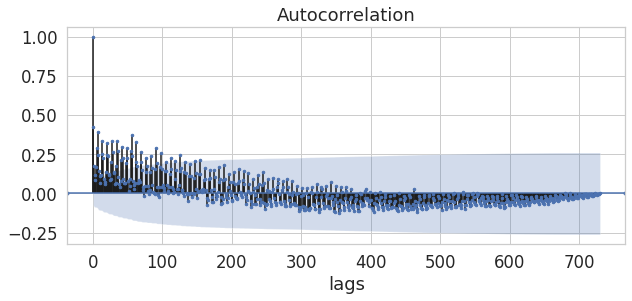

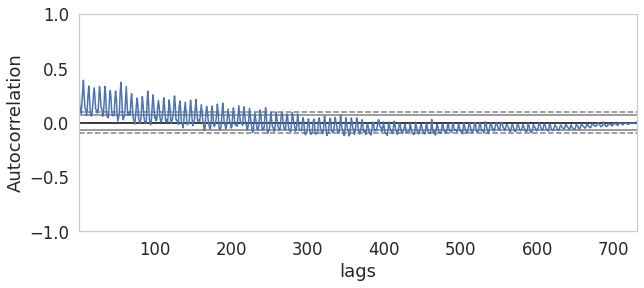

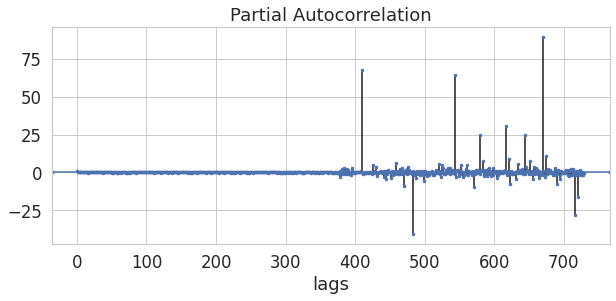

In [ ]:
#para calcular la autocorrelacion y la partial-autocorrelacion se utiliza la librería statmodels en donde toman en cuenta 
#Los intervalos de confianza del 95 % se devuelven cuando la desviación estándar se calcula según la fórmula de Bartlett.
nlags =  365*2
import matplotlib
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
matplotlib.rcParams['figure.figsize'] = [10,4]
plot_acf(dataset_D.cantidad_pasos, lags =np.arange(nlags),use_vlines=True,marker='.')
plt.xlabel('lags')
plt.savefig(path+'autocor1',facecolor='xkcd:white')
plt.show()
from pandas.plotting import autocorrelation_plot
#otra forma para analizar la autocorrelación es mediante la librería pandas. 
#En este caso usa el coeficiente de correlación de Pearson (https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson).
#El coeficiente de correlación de Pearson es una medida de la correlación lineal entre dos variables. El coeficiente de correlación de Pearson tiene un valor entre -1 y 1, donde 0 es ausencia de correlación lineal, >0 es una correlación positiva y <0 es una correlación negativa. La correlación positiva se da cuando dos variables cambian a la par, mientras que un coeficiente de correlación negativo significa que las variables cambian a la inversa.
series =dataset_D.cantidad_pasos
autocorrelation_plot(series)
plt.xlabel('lags')
plt.savefig(path+'autocor2',facecolor='xkcd:white')
plt.show()
matplotlib.rcParams['figure.figsize'] = [10,4]
plot_pacf(dataset_D.cantidad_pasos, lags =np.arange(nlags),marker='.')
plt.xlabel('lags')
plt.savefig(path+'autocor3',facecolor='xkcd:white')
plt.show()






Observando el gráfico de Autocorrelación se tiene que para lags mayores a 100 la serie deja de tener correlación signifactiva. Aún así las correlaciones significativas presentan valores bajos del coeficiente de correlación, con un máximo cercano a 0.5. Es probable que dichos valores se deban a un efecto remanente de la tendencia y ruido que producen una persistencia de corto plazo. Sin embargo,el efecto estacional sólo muestra posibles efectos en los primeros lags. Esto puede tener sentido ya que comparar con datos no distantes en el tiempo indicaría que el comportamiento de la serie se mantuvo cuasi estacionario. Es importante destacar que las correlaciones se mantienen positivas hasta aprox los 100 lags mostrando un efecto de persistencia, pero sólo son importantes los que son significativos mostrando así dependencias con los valores pasados.

Respecto a la autocorrelación parcial nos muestra que para lags mayores a 400 (es decir el presente vs un pasado lejano) el efecto del ruido responde en alguna medida en la correlación parcial. En este caso hay que tener en cuenta que los efectos residuales en parte son dados por los valores extremos que implicaron un cambio abrupto en el flujo vehicular en el pasado. Esto puede tener implicancias a la hora de querer pronosticar a futuro.

In [ ]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))


ADF_test(dataset_D.cantidad_pasos,'raw data')
ADF_test(dataset_D_filtrotend.cantidad_pasos,'raw data')

 > Is the raw data stationary ?
Test statistic = -2.509
P-value = 0.113
Critical values :
	1%: -3.439606888036868 - The data is not stationary with 99% confidence
	5%: -2.865625121924057 - The data is not stationary with 95% confidence
	10%: -2.5689454046801052 - The data is not stationary with 90% confidence
 > Is the raw data stationary ?
Test statistic = -6.792
P-value = 0.000
Critical values :
	1%: -3.441115625417986 - The data is  stationary with 99% confidence
	5%: -2.866289751785392 - The data is  stationary with 95% confidence
	10%: -2.56929951625907 - The data is  stationary with 90% confidence


Por último se observa que bajo el test de Dickey-Fuller la serie sin tendencia es estacionaria ya que el test statistic > crit value. Indicando que es estable a lo largo del tiempo, es decir, cuando la media y varianza son constantes en el tiempo. 
Esto no se observa para el test con la serie con tendencia, con lo cual es bueno a la hora de pronosticar descomponer la serie en tendencial y estacional.

-----------------
-----------------

# Parte B - Modelo de Machine Learning

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el **último trimestre del 2019**. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?
---------




A partir de lo analizado en la Parte A se decide partir el análisis en dos. Una predicción concerniente a la tendencia y el otro a la serie sin tendencia. Esto es debido a la varianza que explican cada una de las componentes de la serie y con ello se querrá observar cuán robustos son los modelos para predecir cada componente. 


fecha
2018-01-01             NaN
2018-01-02             NaN
2018-01-03             NaN
2018-01-04    42891.714286
2018-01-05    45359.571429
                  ...     
2019-12-27    31197.428571
2019-12-28    30801.285714
2019-12-29             NaN
2019-12-30             NaN
2019-12-31             NaN
Freq: D, Name: cantidad_pasos, Length: 730, dtype: float64

In [ ]:
#Dado que me sugieren predecir el último trimestre del 2019, dichos datos serán mi conjunto test y los demás los train
#Modelaré la tendencia y la estacionalidad por separado por el análisis previo.
trend = result_adi.trend
wOut_trend = dataset_D.cantidad_pasos-trend

#train test split simple (para saber el porcentaje de observaciones train y test. luego procedo con un metodo de one step)
X_t = trend.dropna()
train_size = int(len(X_t) * 0.874) #<--- con la serie del 2018-2019 el train con el 0.874 de los datos deja al test con el último trimestre
train_trend, test_trend = X_t[0:train_size], X_t[train_size:len(X_t)]
print('Observations: %d' % (len(X_t)))
print('Training Observations: %d' % (len(train_trend)))
print('Testing Observations: %d' % (len(test_trend)))


X_wOt = wOut_trend.dropna()
train_size = int(len(X_wOt) * 0.874) #<--- con la serie del 2018-2019 el train con el 0.874 de los datos deja al test con el último trimestre
train_wOut_trend, test_wOut_trend = X_wOt[0:train_size], X_wOt[train_size:len(X_wOt)]
print('Observations: %d' % (len(X_wOt)))
print('Training Observations: %d' % (len(train_wOut_trend)))
print('Testing Observations: %d' % (len(test_wOut_trend)))


Observations: 724
Training Observations: 632
Testing Observations: 92
Observations: 724
Training Observations: 632
Testing Observations: 92


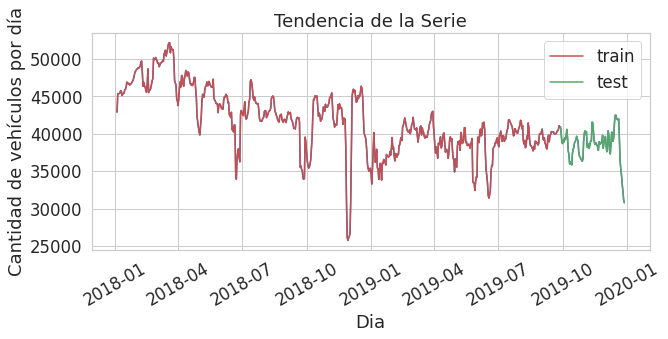

(array([736695., 736785., 736876., 736968., 737060., 737150., 737241.,
        737333., 737425.]), <a list of 9 Text major ticklabel objects>)

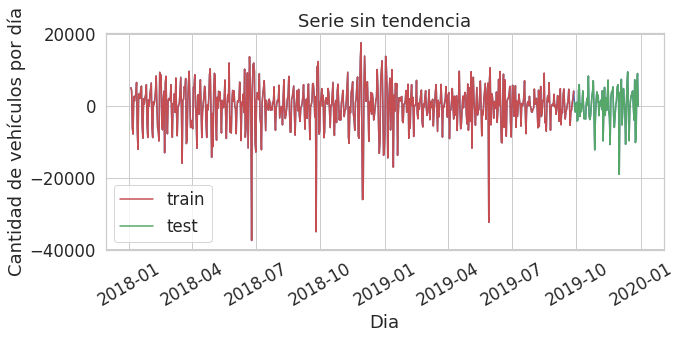

In [ ]:
plt.figure()
plt.plot(X_t)
plt.plot(train_trend,c='r',label='train')
plt.plot(test_trend,c='g',label='test')
plt.legend()
plt.xticks(rotation=30)
plt.title('Tendencia de la Serie')
plt.xlabel('Dia')
plt.ylabel('Cantidad de vehículos por día')

plt.savefig(path+'traintestTendencia',facecolor='xkcd:white')
plt.show()


plt.figure()
plt.plot(X_wOt)
plt.plot(train_wOut_trend,c='r',label='train')
plt.plot(test_wOut_trend,c='g',label='test')
plt.legend()
plt.xticks(rotation=30)
plt.title('Serie sin tendencia')
plt.ylabel('Cantidad de vehículos por día')
plt.xlabel('Dia')
plt.savefig(path+'traintestSinTendencia',facecolor='xkcd:white')

plt.xticks(rotation=30)



In [ ]:
#GENERO EL TRAIN TEST PARA LA SERIE TEMPORAL USANDO METODO ONE-STEP PREDICTION
#Utilizaremos los 21 primeros MESES como conjunto de entrenamiento. Y los 3 últimos Meses como evaluación. 

#se tiene Training Observations: 638 y Testing Observations: 92, este último considera el último trimestre.
#inicialmente considero un lookback de 10 días por la baja correlación en el autocorrelograma
look_back=100 #cuanto del inicio de la serie tomo datos para entrenar mis modelos. Cuanto mayor el look_back más datos del "presente" uso
N_train=623 #resto de dias de los dos años
N_test=92 #tres meses 
length_total_wOt,X_wOt_train,y_wOt_train,X_wOt_test,y_wOt_test,y_wOt= timeseriestraintest(X_wOt,look_back,N_train,N_test)
length_total_t,X_t_train,y_t_train,X_t_test,y_t_test,y_t= timeseriestraintest(X_t,look_back,N_train,N_test)



Observations: 724
Training Observations: 523
Testing Observations: 92
Observations: 724
Training Observations: 523
Testing Observations: 92


-------------

**Importante:** 
Comprobando conun gráfico de cuantiles normales(gráfico de probabilidad normal,TestKol). Aquí los puntos caerían en una línea recta si la muestra fuera exactamente normal. En este caso sería cuasi normal, por lo que no es seguro aplicar el supuesto que la distribución poblacional de la serie es Normal con certeza absoluta. Entonces empleo un preprocesamiento que implica los percentiles y el método IQR, el cual no se sesgará ante distribuciones no normales .
En este caso el valor estandarizado se calcula como (value – median) / (p75 – p25) [RobustScaler](https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/) 
[RobustScaler2](https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff)
La unidad de los datos escalados serán unidades de IQR en función de cuánta distancia estoy respecto a la mediana de mis datos.

La serie presenta un test:  KstestResult(statistic=1.0, pvalue=0.0)


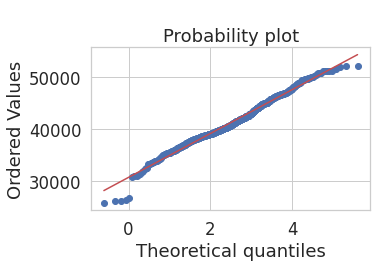

In [ ]:
def TestKol(data):
    """
    Realiza el test de Kolomogorov
    Es una prueba no paramétrica que determina la bondad de ajuste de dos distribuciones de probabilidad entre sí.
    Más información en: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html
    The null-hypothesis for the KT test is that the distributions are the same (normal distribution).
    Thus, the lower your p value the greater the statistical evidence you have to reject the null hypothesis and conclude the distributions are different.
    The test only really lets you speak of your confidence that the distributions are different, not the same, since the test is designed to find alpha, the probability of Type I error. 
    """
    stats.probplot(data.values, dist="norm", sparams=(2.5,),plot=plt)
    plt.title(' \nProbability plot')
    print('La serie presenta un test: ',stats.kstest(data.values, 'norm')) 


#realizo el test en los datos generales
plt.figure(figsize=(5,3))
TestKol(X_t.dropna()) #me indica que la distribución es estadisticamente normal

La serie presenta un test:  KstestResult(statistic=0.569060773480663, pvalue=3.831111737444598e-222)


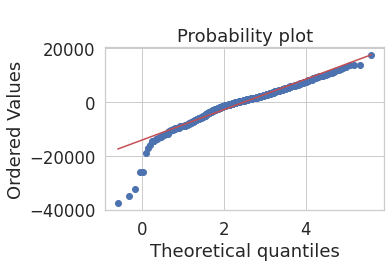

In [ ]:
plt.figure(figsize=(5,3))
TestKol(X_wOt.dropna())#me indica que la distribución es estadisticamente normal

--------------------------

In [ ]:
#realizo un escalado de los datos
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(quantile_range=(25, 75))

#tendencia de la serie
X_t_train_sc= pd.DataFrame(scaler.fit_transform(X_t_train)) #es importante notar que al hacer el escalado lo que devuelve es un array, por lo que se vuelve a transformar en DataFrame para manipular los datos de forma más ordenada.
X_t_test_sc= pd.DataFrame(scaler.transform(X_t_test)) #son instancias que supongo que vendran despues y no los escalos.


#serie sin tendencia
X_wOt_train_sc= pd.DataFrame(scaler.fit_transform(X_wOt_train)) #es importante notar que al hacer el escalado lo que devuelve es un array, por lo que se vuelve a transformar en DataFrame para manipular los datos de forma más ordenada.
X_wOt_test_sc= pd.DataFrame(scaler.transform(X_wOt_test)) #son instancias que supongo que vendran despues y no los escalos.



Para este proyecto se proponene las siguientes métricas de evaluación asociadas al análisis de regresión tipicas en un analisis de serie de tiempo. 

**Mean Absolute Error (MAE)**

El error absoluto medio es la media de los valores absolutos de la desviación. Este tipo de medición del error es útil cuando se miden los errores de predicción en la misma unidad que la serie original.

    -Éste indicará el error medio que puede esperar de la previsión.
    -Es bastante resistente a los valores atípicos. Por lo tanto, el MAE es útil si los datos de entrenamiento están contaminados con valores atípicos y hay grandes valores positivos/negativos en nuestros datos que creemos que podrían no ser el caso en el futuro. 
    -Es buena esta medida de error para comparar entre diferentes modelos.

**Median Absolute Error (MedAE)**

El error absoluto mediano (MedAE) es similar al MAE. Para calcular el MedAE, se toman las diferencias absolutas y se encuentra el valor de la mediana.

    -Al igual que el MAE, la distribución debe ser homogénea e igualmente espaciada para ser útil.
    -Una ventaja interesante es que permite tener en cuenta los valores faltantes. El uso de la mediana es una forma extrema de recortar los valores extremos. Por tanto, el error absoluto de la mediana reduce el sesgo a favor de las previsiones bajas.


**Mean Squared Error (MSE)**


El error medio al cuadrado es la media del cuadrado del error de previsión.

    -Como se toma el cuadrado de los errores, el efecto es que los errores más grandes tienen más peso en la puntuación.
    -Tiene la ventaja de estar en la misma unidad que la variable de previsión.
    -Además, como tanto el MSE como el RMSE toman el cuadrado de los errores, los valores atípicos tendrán un gran efecto en el error resultante.

**Raíz del error cuadrático medio (RMSE)**
    
    -Es la métrica más comúnmente utilizada para las tareas de regresión y representa a la raíz cuadrada de la distancia cuadrada promedio entre el valor real y el valor pronosticado. Indica el ajuste absoluto del modelo a los datos, cuán cerca están los puntos de datos observados de los valores predichos del modelo. 
    -Tiene la propiedad útil de estar en las mismas unidades que la variable de respuesta.
    -RMSE es una buena medida de la precisión con que el modelo predice la respuesta, y es el criterio más importante para ajustar si el propósito principal del modelo es la predicción.
    -Los valores más bajos de RMSE indican un mejor ajuste. 
    -Tiene sus limitaciones: El error es una variable aleatoria numérica y no se puede captar todo el comportamiento de una variable aleatoria con una sola agregación de observaciones. El error es solo una variable aleatoria, a menudo es una variable aleatoria muy sesgada. Cuando predecimos resultados sesgados, como precios, ingresos, ventas de artículos y muchos más, lo más probable es que el error también sea sesgado, lo que significa que en la mayoría de los casos el error es muy pequeño, pero hay relativamente pocos ejemplos que pueden tener errores extremadamente grandes. Cuando el error es muy sesgado, el promedio a menudo no dice nada.


**Coeficiente de determinación R²**

    Determina la capacidad de un modelo para predecir futuros resultados. Es decir, la calidad del modelo para replicar los resultados y la proporción de variación de los resultados que puede explicarse por el modelo.
    El mejor resultado posible es 1, y ocurre cuando la predicción coincide con los valores de la variable objetivo. R2 puede tomar valores negativos pues la predicción puede ser arbitrariamente mala. Cuando la predicción coincide con la esperanza de los valores de la variable objetivo, el resultado de R2 es 0. Se define como 1 menos la suma de cuadrados totales dividido por la suma de cuadrados de los residuos.

[Fuente:Metricas Comunes en Series Temporales](https://joydeep31415.medium.com/common-metrics-for-time-series-analysis-f3ca4b29fe42)
------
**Benchmark:** Se establece la serie del valor de la fecha anterior(su mejor predicciones es su valor inmediatamente anterior).

In [ ]:
#Entrenamos modelos regresores para predecir el último trimestre.
#Entreno los modelos con hiperparámetros elegidos arbitrariamente

#######tendencia de la serie########
#LinearRegresion
L_t= LinearRegression().fit(X_t_train_sc, y_t_train)
#Desiciontree
Dt_t = DecisionTreeRegressor(max_depth=4,random_state=42).fit(X_t_train_sc, y_t_train)
#KNN
knn_t = KNeighborsRegressor(n_neighbors=4,p=2).fit(X_t_train_sc, y_t_train)
#RandomForest
rf_t = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs = 4).fit(X_t_train_sc, y_t_train)
#XGBoost
xgb_t=XGBRegressor(n_estimators=100, random_state=42).fit(X_t_train_sc, y_t_train)
#XGB RandomForest
xgbrf_t=XGBRFRegressor(n_estimators=100, random_state=42,objective ='reg:squarederror', n_jobs = 4).fit(X_t_train_sc, y_t_train)
#Adaboost Model
Ada_t = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=100, random_state=42).fit(X_t_train_sc, y_t_train)



#######Serie sin tendencia########
#LinearRegresion
L_wOt= LinearRegression().fit(X_wOt_train_sc, y_wOt_train)
#Desiciontree
Dt_wOt = DecisionTreeRegressor(max_depth=3,random_state=42).fit(X_wOt_train_sc, y_wOt_train)
#KNN
knn_wOt = KNeighborsRegressor(n_neighbors=3,p=2).fit(X_wOt_train_sc, y_wOt_train)
#RandomForest
rf_wOt = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs = 4).fit(X_wOt_train_sc, y_wOt_train)
#XGBoost
xgb_wOt=XGBRegressor(n_estimators=100, random_state=42).fit(X_wOt_train_sc, y_wOt_train).fit(X_wOt_train_sc, y_wOt_train)
#XGB RandomForest
xgbrf_wOt=XGBRFRegressor(n_estimators=100, random_state=42,objective ='reg:squarederror', n_jobs = 4).fit(X_wOt_train_sc, y_wOt_train)
#Adaboost Model
Ada_wOt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=100, random_state=42).fit(X_wOt_train_sc, y_wOt_train)

[21:04:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<Figure size 720x288 with 0 Axes>

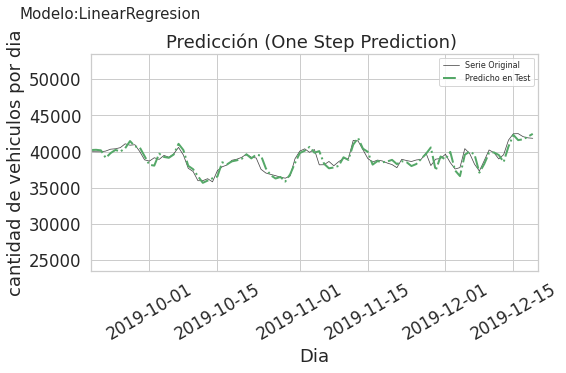

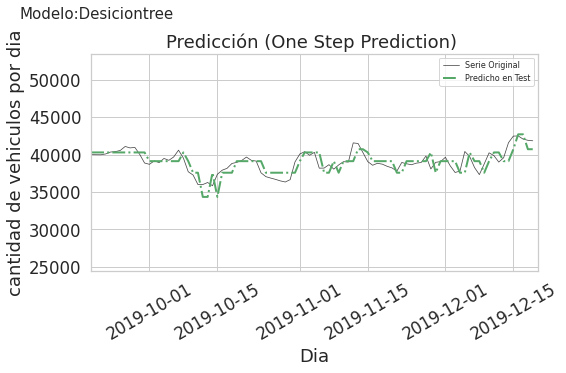

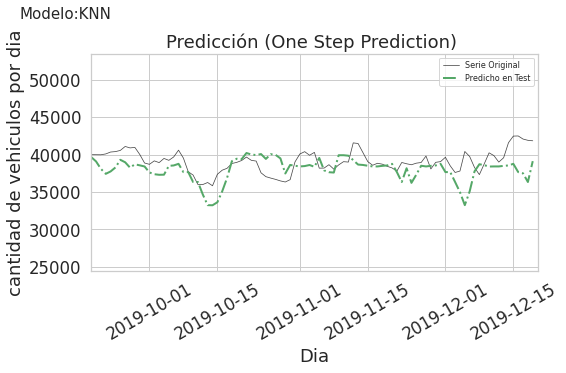

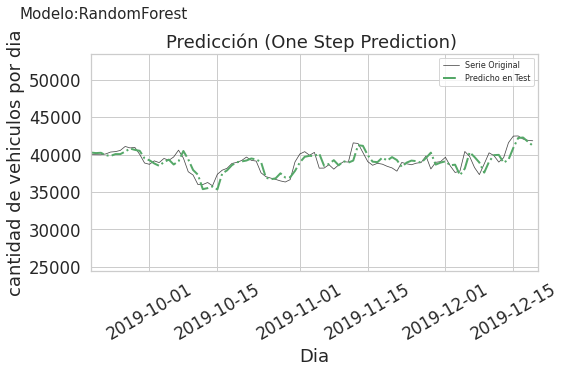

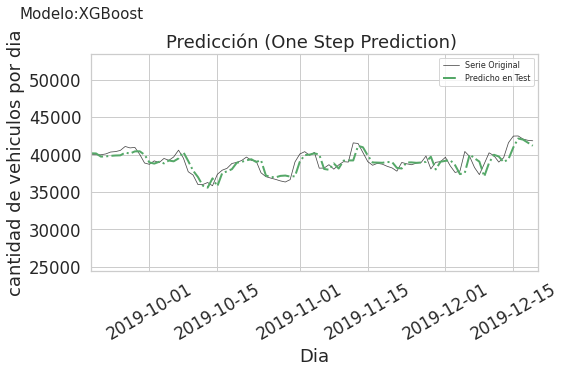

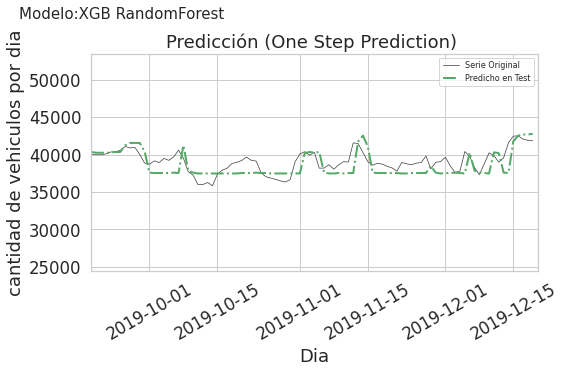

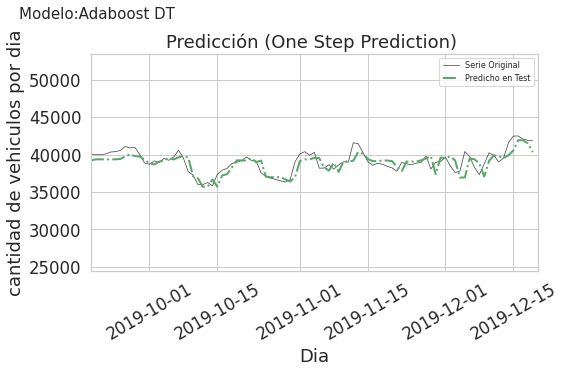

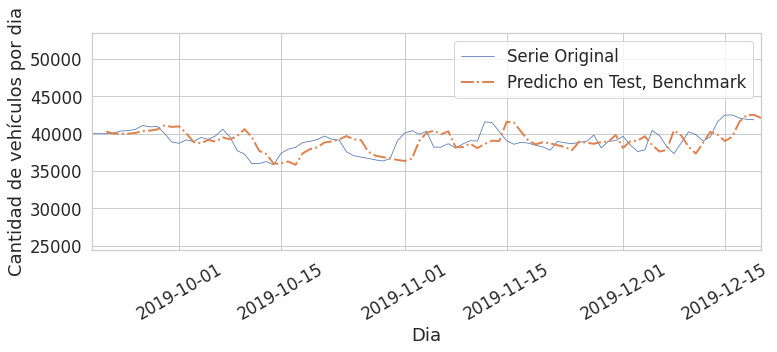

In [ ]:

#tendencia de la serie
plt.figure()
#LinearRegresion
y_train_pred = L_t.predict(X_t_train_sc) #predicción con datos de entrenamiento
y_test_pred = L_t.predict(X_t_test_sc) #predicción con datos de testeo
plotSerie(X_t,N_train,N_test,look_back,length_total_t,y_train_pred,y_test_pred,'LinearRegresion')
S_L_t=MetricasSerie(y_t_train,y_t_test,y_train_pred,y_test_pred,'LinearRegresion')

#Desiciontree
y_train_pred = Dt_t.predict(X_t_train_sc) #predicción con datos de entrenamiento
y_test_pred = Dt_t.predict(X_t_test_sc) #predicción con datos de testeo
plotSerie(X_t,N_train,N_test,look_back,length_total_t,y_train_pred,y_test_pred,'Desiciontree')
S_DT_t=MetricasSerie(y_t_train,y_t_test,y_train_pred,y_test_pred,'Desiciontree')
#KNN
y_train_pred = knn_t.predict(X_t_train_sc) #predicción con datos de entrenamiento
y_test_pred = knn_t.predict(X_t_test_sc) #predicción con datos de testeo
plotSerie(X_t,N_train,N_test,look_back,length_total_t,y_train_pred,y_test_pred,'KNN')
S_KNN_t=MetricasSerie(y_t_train,y_t_test,y_train_pred,y_test_pred,'KNN')
#RandomForest
y_train_pred = rf_t.predict(X_t_train_sc) #predicción con datos de entrenamiento
y_test_pred = rf_t.predict(X_t_test_sc) #predicción con datos de testeo
plotSerie(X_t,N_train,N_test,look_back,length_total_t,y_train_pred,y_test_pred,'RandomForest')
S_RF_t=MetricasSerie(y_t_train,y_t_test,y_train_pred,y_test_pred,'RandomForest')
#XGBoost
y_train_pred = xgb_t.predict(X_t_train_sc) #predicción con datos de entrenamiento
y_test_pred = xgb_t.predict(X_t_test_sc) #predicción con datos de testeo
plotSerie(X_t,N_train,N_test,look_back,length_total_t,y_train_pred,y_test_pred,'XGBoost')
S_XGB_t=MetricasSerie(y_t_train,y_t_test,y_train_pred,y_test_pred,'XGBoost')
#XGB RandomForest
y_train_pred = xgbrf_t.predict(X_t_train_sc) #predicción con datos de entrenamiento
y_test_pred = xgbrf_t.predict(X_t_test_sc) #predicción con datos de testeo
plotSerie(X_t,N_train,N_test,look_back,length_total_t,y_train_pred,y_test_pred,'XGB RandomForest')
S_XGBRF_t=MetricasSerie(y_t_train,y_t_test,y_train_pred,y_test_pred,'XGB RandomForest')
#Adaboost Model
y_train_pred = Ada_t.predict(X_t_train_sc) #predicción con datos de entrenamiento
y_test_pred = Ada_t.predict(X_t_test_sc) #predicción con datos de testeo
plotSerie(X_t,N_train,N_test,look_back,length_total_t,y_train_pred,y_test_pred,'Adaboost DT')
S_ADA_t=MetricasSerie(y_t_train,y_t_test,y_train_pred,y_test_pred,'Adaboost DT')

#Benchmark de la serie de tendencia
y_test_pred_benchmark = X_t[-1 + N_train:N_train+N_test - 1]
S_bench_t=MetricasSerie(y_t_train,y_t_test,y_train_pred,y_test_pred_benchmark,'Benchmark')

plt.figure(figsize=(12,4))
plt.plot(X_t.index[:length_total_t], X_t[:length_total_t],lw = 0.75, label = 'Serie Original')
plt.plot(X_t.index[N_train+N_test-look_back+10:length_total_t+2], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(X_t.index[N_train], X_t.index[length_total_t])
plt.legend()
plt.ylabel('Cantidad de vehículos por dia')
plt.xlabel('Dia')
plt.xticks(rotation=30)
plt.savefig(path+'benchmarktendencia',facecolor='xkcd:white')
plt.show()

En términos generales se puede observar que todos los modelos actuaron de manera "estable" es decir que los órdenes de magnitud que devolvieron estaban en las mismas medidas que tenían los valores de testeo. Salvo el KNN y el XGB RF que mostraron algunos elementos más extremos, los demás modelos presentaron un comportamiento parecido a lo observado. 
Para analizar mejor se estudian las metricas de desempeño.

In [ ]:

#Genero una tabla de los scores para los distintos modelos 
SCOR_t=pd.DataFrame([S_L_t,S_DT_t,S_KNN_t,S_RF_t,S_XGB_t,S_XGBRF_t,S_ADA_t,S_bench_t],columns=['Modelo','MAE_train','MAE_test','MedAE_train','MedAE_test','MSE_train','MSE_test','RMSE_train','RMSE_test','R2_train','R2_test'])

#media de resultados

mean_mae_train_t=np.nanmean(SCOR_t.MAE_train)
mean_mae_test_t=np.nanmean(SCOR_t.MAE_test)
mean_mse_train_t=np.nanmean(SCOR_t.MSE_train)
mean_mse_test_t=np.nanmean(SCOR_t.MSE_test)
mean_rmse_train_t=np.nanmean(SCOR_t.RMSE_train)
mean_rmse_test_t=np.nanmean(SCOR_t.RMSE_test)
mean_r2_train_t=np.nanmean(SCOR_t.R2_train)
mean_r2_test_t=np.nanmean(SCOR_t.R2_test)
labels_t=SCOR_t.Modelo
SCOR_t


Modelo    MAE_train     MAE_test  ...    RMSE_test  R2_train   R2_test
0   LinearRegresion   526.722180   504.593130  ...   668.903317  0.952529  0.796621
1      Desiciontree   715.943793   820.539269  ...  1061.786120  0.914828  0.487548
2               KNN   529.385277  1654.281056  ...  2110.444648  0.952114 -1.024542
3      RandomForest   307.155367   665.453261  ...   888.658304  0.978891  0.641038
4           XGBoost   389.120737   659.267906  ...   873.889136  0.978114  0.652870
5  XGB RandomForest  1628.608573  1134.813646  ...  1415.553773  0.608450  0.089182
6       Adaboost DT   607.865919   750.988109  ...   971.511581  0.958470  0.570983
7         Benchmark          NaN   623.645963  ...   869.675889       NaN  0.656210

[8 rows x 11 columns]

<Figure size 720x288 with 0 Axes>

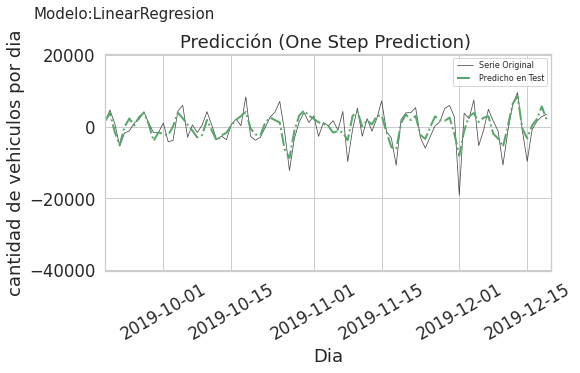

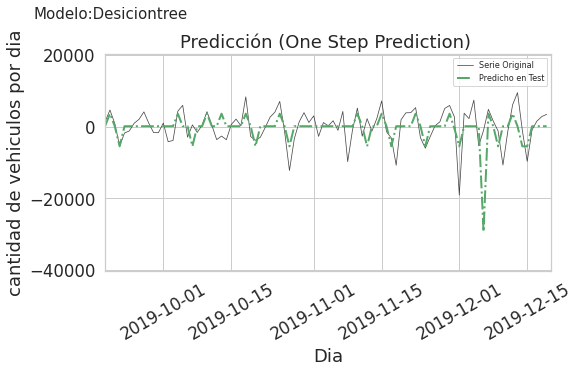

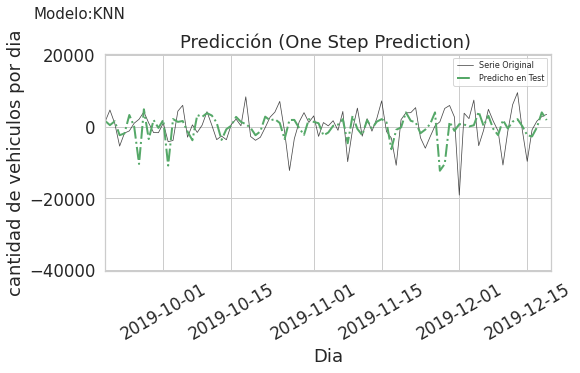

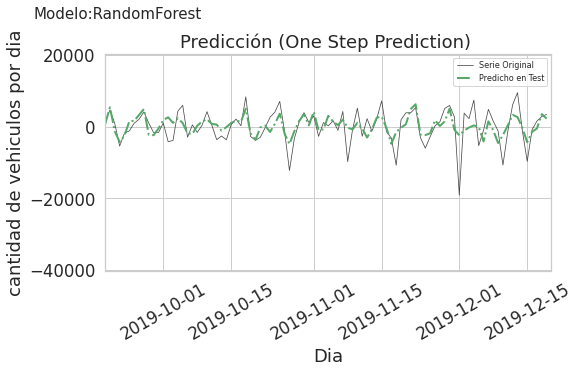

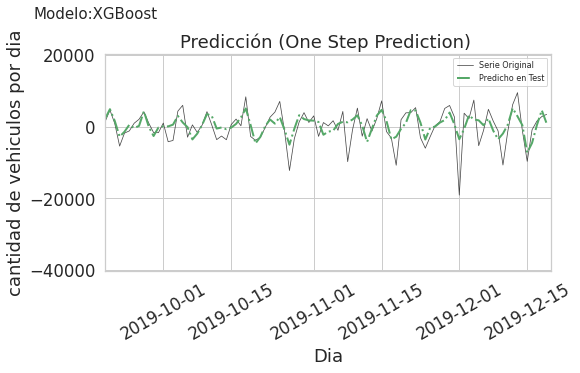

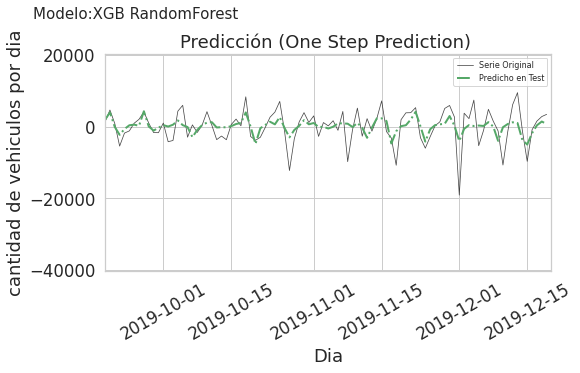

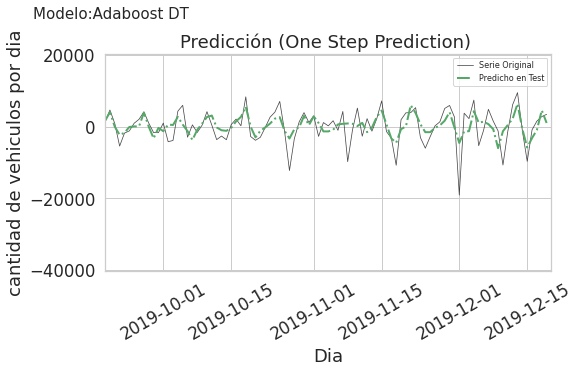

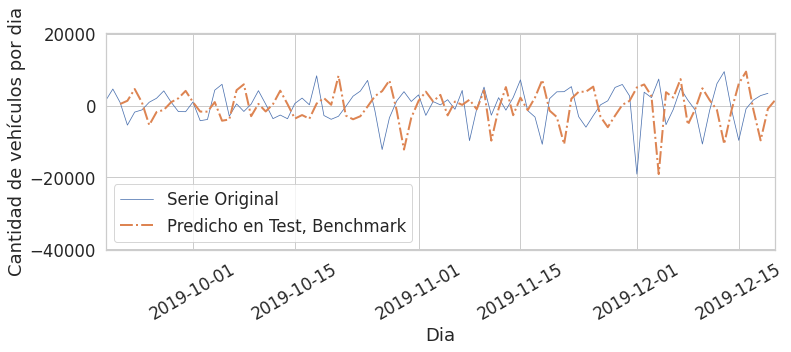

In [ ]:

#Serie sin tendencia
plt.figure()
#LinearRegresion
y_train_pred = L_wOt.predict(X_wOt_train_sc) #predicción con datos de entrenamiento
y_test_pred = L_wOt.predict(X_wOt_test_sc) #predicción con datos de testeo
plotSerie(X_wOt,N_train,N_test,look_back,length_total_wOt,y_train_pred,y_test_pred,'LinearRegresion')
S_L=MetricasSerie(y_wOt_train,y_wOt_test,y_train_pred,y_test_pred,'LinearRegresion')

#Desiciontree
y_train_pred = Dt_wOt.predict(X_wOt_train_sc) #predicción con datos de entrenamiento
y_test_pred = Dt_wOt.predict(X_wOt_test_sc) #predicción con datos de testeo
plotSerie(X_wOt,N_train,N_test,look_back,length_total_wOt,y_train_pred,y_test_pred,'Desiciontree')
S_DT=MetricasSerie(y_wOt_train,y_wOt_test,y_train_pred,y_test_pred,'Desiciontree')

#KNN
y_train_pred = knn_wOt.predict(X_wOt_train_sc) #predicción con datos de entrenamiento
y_test_pred = knn_wOt.predict(X_wOt_test_sc) #predicción con datos de testeo
plotSerie(X_wOt,N_train,N_test,look_back,length_total_wOt,y_train_pred,y_test_pred,'KNN')
S_KNN=MetricasSerie(y_wOt_train,y_wOt_test,y_train_pred,y_test_pred,'KNN')

#RandomForest
y_train_pred = rf_wOt.predict(X_wOt_train_sc) #predicción con datos de entrenamiento
y_test_pred = rf_wOt.predict(X_wOt_test_sc) #predicción con datos de testeo
plotSerie(X_wOt,N_train,N_test,look_back,length_total_wOt,y_train_pred,y_test_pred,'RandomForest')
S_RF=MetricasSerie(y_wOt_train,y_wOt_test,y_train_pred,y_test_pred,'RandomForest')

#XGBoost
y_train_pred = xgb_wOt.predict(X_wOt_train_sc) #predicción con datos de entrenamiento
y_test_pred = xgb_wOt.predict(X_wOt_test_sc) #predicción con datos de testeo
plotSerie(X_wOt,N_train,N_test,look_back,length_total_wOt,y_train_pred,y_test_pred,'XGBoost')
S_XGB=MetricasSerie(y_wOt_train,y_wOt_test,y_train_pred,y_test_pred,'XGBoost')

#XGB RandomForest
y_train_pred = xgbrf_wOt.predict(X_wOt_train_sc) #predicción con datos de entrenamiento
y_test_pred = xgbrf_wOt.predict(X_wOt_test_sc) #predicción con datos de testeo
plotSerie(X_wOt,N_train,N_test,look_back,length_total_wOt,y_train_pred,y_test_pred,'XGB RandomForest')
S_XGBRF=MetricasSerie(y_wOt_train,y_wOt_test,y_train_pred,y_test_pred,'XGB RandomForest')

#Adaboost Model
y_train_pred = Ada_wOt.predict(X_wOt_train_sc) #predicción con datos de entrenamiento
y_test_pred = Ada_wOt.predict(X_wOt_test_sc) #predicción con datos de testeo
plotSerie(X_wOt,N_train,N_test,look_back,length_total_wOt,y_train_pred,y_test_pred,'Adaboost DT')
S_ADA=MetricasSerie(y_wOt_train,y_wOt_test,y_train_pred,y_test_pred,'Adaboost DT')


#Benchmark de la serie de tendencia
y_test_pred_benchmark = X_wOt[-1 + N_train:N_train+N_test - 1]
S_bench=MetricasSerie(y_wOt_train,y_wOt_test,y_train_pred,y_test_pred_benchmark,'Benchmark')

plt.figure(figsize=(12,4))
plt.plot(X_wOt.index[:length_total_t], X_wOt[:length_total_t],lw = 0.75, label = 'Serie Original')
plt.plot(X_wOt.index[N_train+N_test-look_back+10:length_total_t+2], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(X_wOt.index[N_train], X_wOt.index[length_total_t])
plt.legend()
plt.ylabel('Cantidad de vehículos por dia')
plt.xlabel('Dia')
plt.xticks(rotation=30)
plt.savefig(path+'benchmarksintendencia',facecolor='xkcd:white')
plt.show()




En este caso para replicar la serie sin tendencia los mayores inconvenientes se observaron en los cambios abruptos. Donde en varios casos se tuvo un desfasaje del pico o una pronunciación del valor extremo (ejemplo en el DT o KNN). En otros casos el valor estuvo subestimado, evidenciando que capturaban el comportamiento de la serie en su evolución mas no así los cambios abruptos.

In [ ]:
#Genero una tabla de los scores para los distintos modelos 
SCOR_wOt=pd.DataFrame([S_L,S_DT,S_KNN,S_RF,S_XGB,S_XGBRF,S_ADA,S_bench],columns=['Modelo','MAE_train','MAE_test','MedAE_train','MedAE_test','MSE_train','MSE_test','RMSE_train','RMSE_test','R2_train','R2_test'])

#media de resultados

mean_mae_train=np.nanmean(SCOR_wOt.MAE_train)
mean_mae_test=np.nanmean(SCOR_wOt.MAE_test)
mean_mse_train=np.nanmean(SCOR_wOt.MSE_train)
mean_mse_test=np.nanmean(SCOR_wOt.MSE_test)
mean_rmse_train=np.nanmean(SCOR_wOt.RMSE_train)
mean_rmse_test=np.nanmean(SCOR_wOt.RMSE_test)
mean_r2_train=np.nanmean(SCOR_wOt.R2_train)
mean_r2_test=np.nanmean(SCOR_wOt.R2_test)
labels=SCOR_wOt.Modelo

SCOR_wOt



Modelo    MAE_train     MAE_test  ...    RMSE_test  R2_train   R2_test
0   LinearRegresion  2440.489463  2222.539349  ...  2927.640592  0.657066  0.604394
1      Desiciontree  3343.821855  3234.537458  ...  4886.508847  0.384881 -0.102110
2               KNN  2901.526814  3703.224638  ...  5192.314007  0.501709 -0.244370
3      RandomForest  1446.286916  2582.330280  ...  3636.750123  0.836631  0.389544
4           XGBoost  1457.779860  2589.408762  ...  3552.601687  0.897324  0.417467
5  XGB RandomForest  2957.812511  2770.389748  ...  3789.843826  0.474745  0.337066
6       Adaboost DT  2386.565577  2660.210412  ...  3532.355442  0.763284  0.424088
7         Benchmark          NaN  4695.260870  ...  6277.313882       NaN -0.818759

[8 rows x 11 columns]

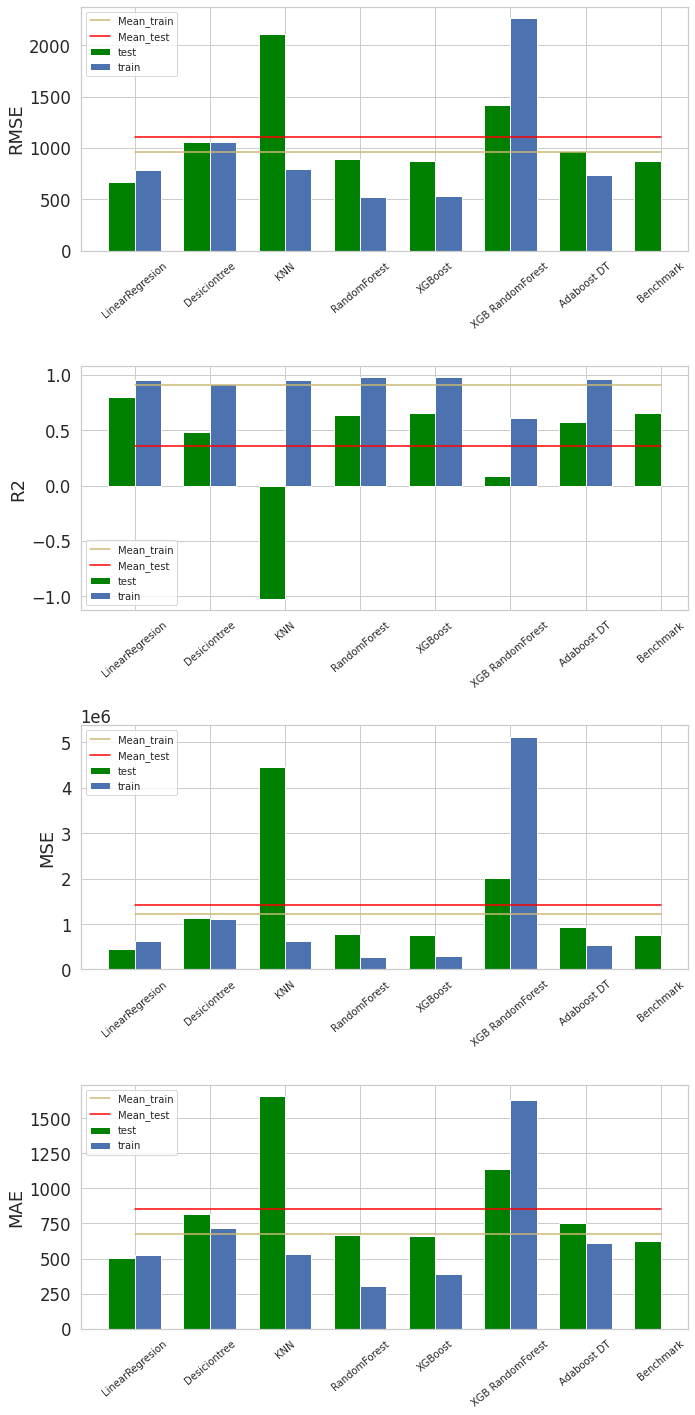

In [ ]:
#Grafico la metrica en funcion del modelo y los datos train/test
#Tendencia de la serie

x = np.arange(len(labels_t))
width = 0.35  # the width of the bars

fig, axs = plt.subplots(4,figsize=(10,20))
fig.patch.set_facecolor('xkcd:white')

rects1 = axs[0].bar(x - width/2, SCOR_t.RMSE_test, width, label='test',color='green')
rects2 = axs[0].bar(x + width/2, SCOR_t.RMSE_train, width, label='train')
# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_ylabel('RMSE')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels_t)
autolabel(rects1)
autolabel(rects2)
axs[0].plot(x,np.full((len(x), 1), mean_rmse_train_t),'y',label='Mean_train')
axs[0].plot(x, np.full((len(x), 1), mean_rmse_test_t),color='red',label='Mean_test')
axs[0].legend(fontsize='10')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels_t, rotation=40,fontsize=10)
######################################

rects1 = axs[1].bar(x - width/2, SCOR_t.R2_test, width, label='test',color='green')
rects2 = axs[1].bar(x + width/2, SCOR_t.R2_train, width, label='train')
# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_ylabel('R2')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels_t)
autolabel(rects1)
autolabel(rects2)
axs[1].plot(x, np.full((len(x), 1), mean_r2_train_t),color='y',label='Mean_train')
axs[1].plot(x, np.full((len(x), 1), mean_r2_test_t),color='red',label='Mean_test')
axs[1].legend(fontsize='10')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels_t, rotation=40,fontsize=10)
######################################

rects1 = axs[2].bar(x - width/2, SCOR_t.MSE_test, width, label='test',color='green')
rects2 = axs[2].bar(x + width/2, SCOR_t.MSE_train, width, label='train')
# Add some text for labels, title and custom x-axis tick labels, etc.
axs[2].set_ylabel('MSE')
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels_t)
autolabel(rects1)
autolabel(rects2)
axs[2].plot(x, np.full((len(x), 1), mean_mse_train_t),color='y',label='Mean_train')
axs[2].plot(x, np.full((len(x), 1), mean_mse_test_t),color='red',label='Mean_test')
axs[2].legend(fontsize='10')
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels_t, rotation=40,fontsize=10)

######################################

rects1 = axs[3].bar(x - width/2, SCOR_t.MAE_test, width, label='test',color='green')
rects2 = axs[3].bar(x + width/2, SCOR_t.MAE_train, width, label='train')
# Add some text for labels, title and custom x-axis tick labels, etc.
axs[3].set_ylabel('MAE')
axs[3].set_xticks(x)
axs[3].set_xticklabels(labels_t)
autolabel(rects1)
autolabel(rects2)
axs[3].plot(x, np.full((len(x), 1), mean_mae_train_t),color='y',label='Mean_train')
axs[3].plot(x, np.full((len(x), 1), mean_mae_test_t),color='red',label='Mean_test')
axs[3].legend(fontsize='10')
axs[3].set_xticks(x)
axs[3].set_xticklabels(labels_t, rotation=40,fontsize=10)
fig.tight_layout()
plt.savefig(path+'MetricasTendencia')
plt.show()




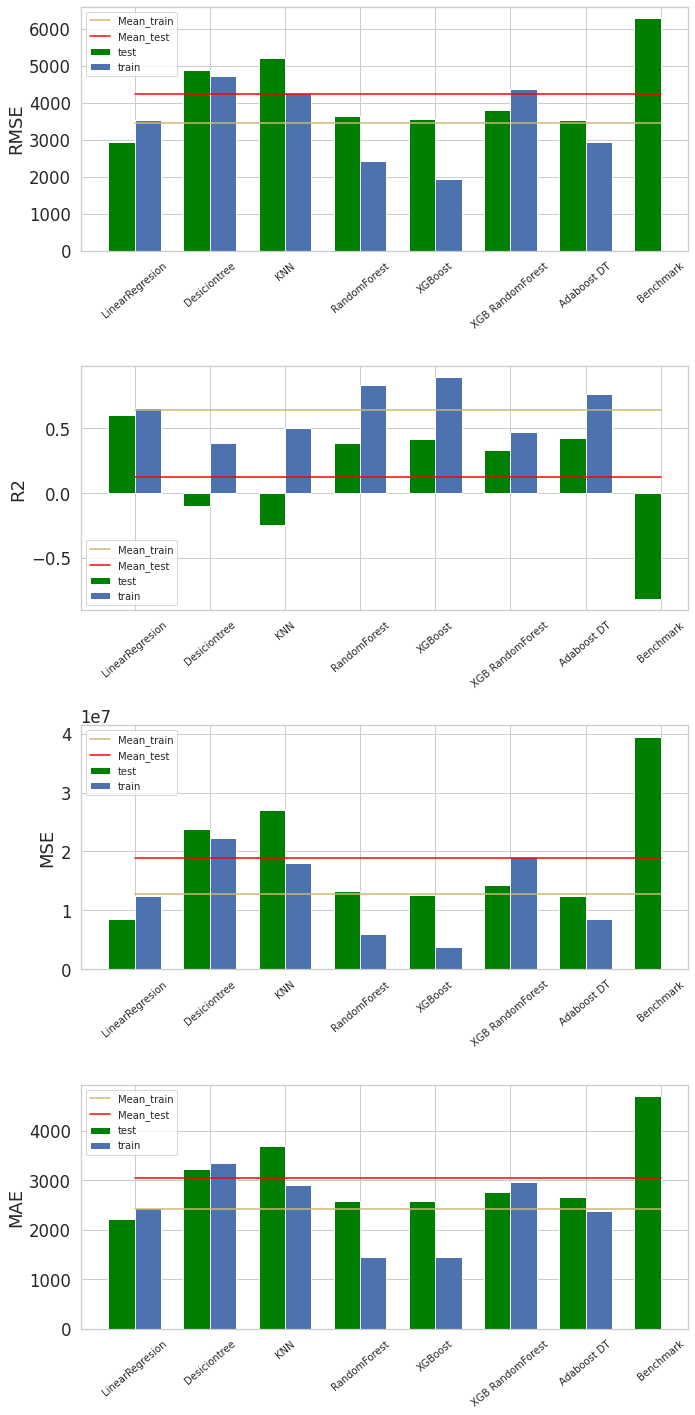

In [ ]:

#Serie sin Tendencia
x = np.arange(len(labels))
width = 0.35  # the width of the bars

fig, axs = plt.subplots(4,figsize=(10,20))
fig.patch.set_facecolor('xkcd:white')

rects1 = axs[0].bar(x - width/2, SCOR_wOt.RMSE_test, width, label='test',color='green')
rects2 = axs[0].bar(x + width/2, SCOR_wOt.RMSE_train, width, label='train')
# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_ylabel('RMSE')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels)
autolabel(rects1)
autolabel(rects2)
axs[0].plot(x,np.full((len(x), 1), mean_rmse_train),'y',label='Mean_train')
axs[0].plot(x, np.full((len(x), 1), mean_rmse_test),color='red',label='Mean_test')
axs[0].legend(fontsize='10')
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, rotation=40,fontsize=10)
######################################

rects1 = axs[1].bar(x - width/2, SCOR_wOt.R2_test, width, label='test',color='green')
rects2 = axs[1].bar(x + width/2, SCOR_wOt.R2_train, width, label='train')
# Add some text for labels, title and custom x-axis tick labels, etc.
axs[1].set_ylabel('R2')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels)
autolabel(rects1)
autolabel(rects2)
axs[1].plot(x, np.full((len(x), 1), mean_r2_train),color='y',label='Mean_train')
axs[1].plot(x, np.full((len(x), 1), mean_r2_test),color='red',label='Mean_test')
axs[1].legend(fontsize='10')
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, rotation=40,fontsize=10)
######################################

rects1 = axs[2].bar(x - width/2, SCOR_wOt.MSE_test, width, label='test',color='green')
rects2 = axs[2].bar(x + width/2, SCOR_wOt.MSE_train, width, label='train')
# Add some text for labels, title and custom x-axis tick labels, etc.
axs[2].set_ylabel('MSE')
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels)
autolabel(rects1)
autolabel(rects2)
axs[2].plot(x, np.full((len(x), 1), mean_mse_train),color='y',label='Mean_train')
axs[2].plot(x, np.full((len(x), 1), mean_mse_test),color='red',label='Mean_test')
axs[2].legend(fontsize='10')
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels, rotation=40,fontsize=10)

######################################

rects1 = axs[3].bar(x - width/2, SCOR_wOt.MAE_test, width, label='test',color='green')
rects2 = axs[3].bar(x + width/2, SCOR_wOt.MAE_train, width, label='train')
# Add some text for labels, title and custom x-axis tick labels, etc.
axs[3].set_ylabel('MAE')
axs[3].set_xticks(x)
axs[3].set_xticklabels(labels)
autolabel(rects1)
autolabel(rects2)
axs[3].plot(x, np.full((len(x), 1), mean_mae_train),color='y',label='Mean_train')
axs[3].plot(x, np.full((len(x), 1), mean_mae_test),color='red',label='Mean_test')
axs[3].legend(fontsize='10')
axs[3].set_xticks(x)
axs[3].set_xticklabels(labels, rotation=40,fontsize=10)
fig.tight_layout()
plt.savefig(path+'Metricassintendencia')
plt.show()


A simple vista podemos tener una idea del comportamiento de los modelos estudiados previamente. En términos generales considero que para tener una desición sobre el mejor modelo, que no tienda ni a overfitting ni underfitting, tomar como referencia la media de las métricas obtenidas para tener una base de comparación.
##Para la tendencia de la serie total
Se observa que los modelos salvo el linearRegression muestran una peor performance que el benchmark (en especial el Knn y XGBRF). En términos generales el Linear Regression posee una ganacia marginal respecto al benchmark. Respecto a lo obtenido con la tendencia de la serie el ADAboost no posee una desmejora grande respecto al benchmark, por lo que también si se puede optimizar puede que se genere una mejora.




##Para la serie sin tendencia
En términos generales los modelos mejoran la performance del test del benchmark. 
Analizando los modelos particulares observamos que los modelos Knn y DT con parámetros a elección (random) dieron la peor performance, mientras que el Adaboost o el linearRegression muestran buenas metricas. En términos generales la desición se toma por cómo fue el rendimiento en el R2 y el RMSE. 
En términos generales se observa una sobreestimación del flujo vehicular de alrededor de 3000-4000 vehículos por día.


En conclusión la desición de prosegir con ADABoost DT se debe a los resultados obtenidos. El LR queda como un segundo Benchmark ya que al ser un modelo no parametrico no puedo optimizar directamente con la libreria de sklearn.





##**Optimización de los hiperparámetros de modelo**



  


In [ ]:
param_dist = {'n_estimators': [10,50,100,200,300,400,500,700,1000], 'learning_rate' : [0.001,0.005,0.01,0.05,0.1,0.5,1], 'loss' : ['linear', 'square', 'exponential']}
ADADT_RS_t=RandomizedSearchCV(AdaBoostRegressor(), param_distributions = param_dist, cv=5,  n_iter = 10, n_jobs=-1,scoring='neg_root_mean_squared_error').fit(X_t_train_sc,y_t_train)
print('The best parameteres after RandomSearchCV', ADADT_RS_t.best_params_)
print('The best estimator after RandomSearchCV',ADADT_RS_t.best_estimator_)
print('The best score RMSE after RandomSearchCV',-ADADT_RS_t.best_score_)

ADADT_RS_wOt=RandomizedSearchCV(AdaBoostRegressor(), param_distributions = param_dist, cv=5,  n_iter = 10, n_jobs=-1,scoring='neg_root_mean_squared_error').fit(X_wOt_train_sc,y_wOt_train)
print('The best parameteres after RandomSearchCV', ADADT_RS_wOt.best_params_)
print('The best estimator after RandomSearchCV',ADADT_RS_wOt.best_estimator_)
print('The best score RMSE after RandomSearchCV',-ADADT_RS_wOt.best_score_)



The best parameteres after RandomSearchCV {'n_estimators': 400, 'loss': 'exponential', 'learning_rate': 0.001}
The best estimator after RandomSearchCV AdaBoostRegressor(base_estimator=None, learning_rate=0.001, loss='exponential',
                  n_estimators=400, random_state=None)
The best score RMSE after RandomSearchCV 1477.5117945992856
The best parameteres after RandomSearchCV {'n_estimators': 700, 'loss': 'linear', 'learning_rate': 0.05}
The best estimator after RandomSearchCV AdaBoostRegressor(base_estimator=None, learning_rate=0.05, loss='linear',
                  n_estimators=700, random_state=None)
The best score RMSE after RandomSearchCV 5240.826208928759


In [ ]:
param_dist = {'n_estimators': [400,500,700,800,1000,1100], 'learning_rate' : [0.0009,0.001,0.005,0.01,0.05,0.06], 'loss' : ['linear', 'square', 'exponential']}



ADADT_GS_t = GridSearchCV(AdaBoostRegressor(), param_grid = param_dist, cv=5,  n_jobs=-1,scoring='neg_root_mean_squared_error').fit(X_t_train_sc,y_t_train)

print('The best parameteres after GridSearchCV', ADADT_GS_t.best_params_)
print('The best estimator after GridSearchCV',ADADT_GS_t.best_estimator_)
print('The best score (RMSE) after GridSearchCV',-ADADT_GS_t.best_score_)
ADADT_GS_wOt = GridSearchCV(AdaBoostRegressor(), param_grid = param_dist, cv=5,   n_jobs=-1,scoring='neg_root_mean_squared_error').fit(X_wOt_train_sc,y_wOt_train)
print('The best parameteres after GridSearchCV', ADADT_GS_wOt.best_params_)
print('The best estimator after GridSearchCV',ADADT_GS_wOt.best_estimator_)
print('The best score (RMSE) after GridSearchCV',-ADADT_GS_wOt.best_score_)



The best parameteres after GridSearchCV {'learning_rate': 0.001, 'loss': 'exponential', 'n_estimators': 500}
The best estimator after GridSearchCV AdaBoostRegressor(base_estimator=None, learning_rate=0.001, loss='exponential',
                  n_estimators=500, random_state=None)
The best score (RMSE after GridSearchCV 1478.1502948114876
The best parameteres after GridSearchCV {'learning_rate': 0.06, 'loss': 'exponential', 'n_estimators': 400}
The best estimator after GridSearchCV AdaBoostRegressor(base_estimator=None, learning_rate=0.06, loss='exponential',
                  n_estimators=400, random_state=None)
The best score (RMSE after GridSearchCV 5194.175860148024


Según el análisis de Random y GridSearch para la tendencia de la serie los mejores hiperparámetros fueron

    -'learning_rate': 0.001
    -'loss': 'linear'
    -'n_estimators': 400
    - Estimacion del error RMSE de 1478.13


Mientras que para la serie sin tendencia los mejores hiperparámetros fueron:

    -'learning_rate': 0.01
    -'loss': 'exponential'
    -'n_estimators': 1100
    - Estimacion del errorn RMSE de  5185.45

Aclaración: estos datos fueron obtenidos con la optimización de hiperparámetros realizada cuando hice el análisis. Es probable que algun valor cambie porque no es un proceso exacto y la aleatoriedad puede influir en los cambios de parámetros. Es por esto que de aquí en más se usan los hiperparámetros encontrados en mi análisis.


Error RMSE en datos de train: 985.2369
Error RMSE en datos de test: 904.2099
Error (R2) en datos de train: 0.92574
Error (R2) en datos de test: 0.62836


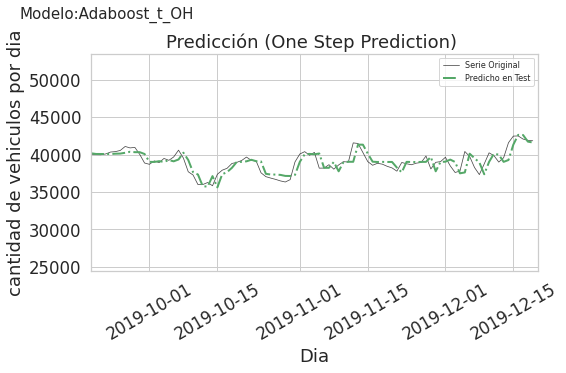

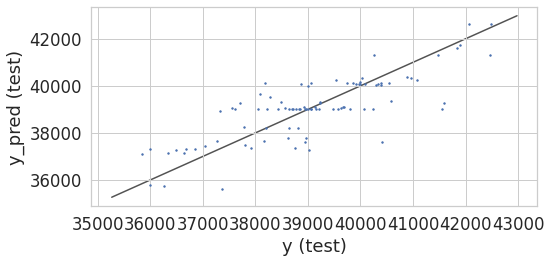

Error RMSE en datos de train: 3265.7265
Error RMSE en datos de test: 3586.6107
Error (R2) en datos de train: 0.70583
Error (R2) en datos de test: 0.40626


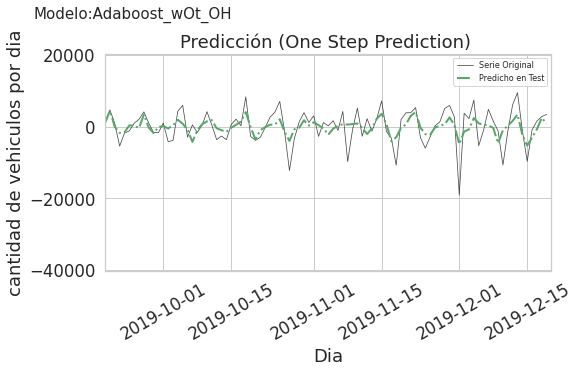

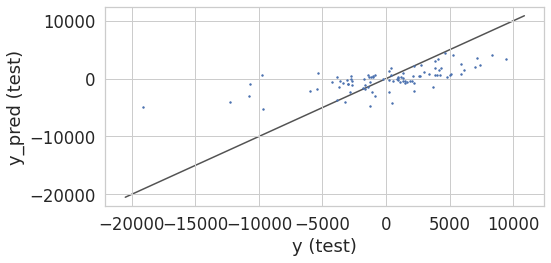

In [ ]:
#Veré el desempeño de mis modelos con parámetros optimizados dejando DTregressor con max_depth 4.

Ada_t = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=400,learning_rate= 0.001,loss= 'linear', random_state=42).fit(X_t_train_sc, y_t_train)
y_train_pred = Ada_t.predict(X_t_train_sc) #predicción con datos de entrenamiento
y_test_pred = Ada_t.predict(X_t_test_sc) #predicción con datos de testeo
plotSerie(X_t,N_train,N_test,look_back,length_total_t,y_train_pred,y_test_pred,'Adaboost_t_OH')
evaluar_model(Ada_t,X_t_train_sc, X_t_test_sc, y_t_train, y_t_test,modelo_a_evaluar='AdaBoostDT_tHO')


Ada_wOt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=1100, learning_rate= 0.01,loss= 'exponential',random_state=42).fit(X_wOt_train_sc, y_wOt_train)
y_train_pred = Ada_wOt.predict(X_wOt_train_sc) #predicción con datos de entrenamiento
y_test_pred = Ada_wOt.predict(X_wOt_test_sc) #predicción con datos de testeo
plotSerie(X_wOt,N_train,N_test,look_back,length_total_wOt,y_train_pred,y_test_pred,'Adaboost_wOt_OH')
evaluar_model(Ada_wOt,X_wOt_train_sc, X_wOt_test_sc, y_wOt_train, y_wOt_test,modelo_a_evaluar='AdaBoostDT_wotHO')

En términos del R2 la ganancia en el test es marginal 
para la tendencia de la serie en el test pasa de 0.57 a 0.63, mientras que para la serie sin tendencia el cambio es de 0.424 a 0.406 en los datos test.
En términos de RMSE la ganancia también es marginal en el test para ambos casos, aunque se observó un aumento del RMSE en train, eso por un lado nos puede dar indicio de que aún no tendería a sobreajustarse.

Sin la tendencia.

    sin HO:  RMSE train 2929.528672    RMSE test 3532.355442
    con HO:  RMSE train 3265.7265      RMSE test 3586.6107
    Si se compara con el benchmark y la regresión lineal (para datos test) se tiene que el desempeño con HO mejora considerablemente respecto al bench mas respecto a la regresion no se ve dicha mejora.  (RMSE_test_LR  2927.640592  RMSE_test_Bench 6277.313882

La tendencia 


    sin HO:  RMSE train 736.784822    RMSE test 971.511581
    con HO:  RMSE train 985.2369      RMSE test 904.2099
    Si se compara con el benchmark y la regresión lineal (para datos test) se tiene que el desempeño con HO empeora levemente respecto al bench y mucho más respecto a la regresion.  (RMSE_test_LR  668.903317  RMSE_test_Bench 869.675889


Observando la gráfica de la evolución temporal predicha del flujo vehicular se tiene que la serie de tendencia se predice con un leve desfasaje, mas los valores parecen ser acordes a lo observado. Sin embargo, para la serie sin tendencia los cambios abruptos son aún un tema para mejorar en la predicción, ya que el modelo no captura enteramente los efectos ciclicos de mayor importancia.


Por último analizando los gráficos de Y predicho vs y real se tiene que para el pronóstico de la tendencia una leve sobreestimación del modelo para todos los rangos posibles de la serie.
Mientras que para la serie sin la tendencia el modelo tiende a sobre estimar valores chicos y subestimar valores grandes (es decir que la oscilación de la serie es más atenuada de lo que en realidad es).


-----------------------
###**Si el modelo lo permite, debes explorar qué información utiliza para predecir e interpretar ese resultado. ¿Coincide con lo que esperabas a partir de tu experiencia con el dataset?**


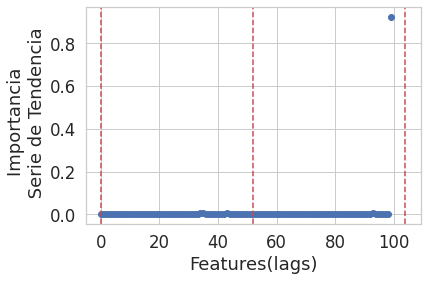

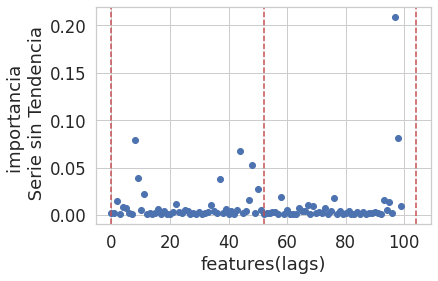

In [ ]:
#Para analizar qué información el modelo Optimizado de Adaboost utiliza se observa la importancia de features
#En este caso cada feature es un tiempo de la serie temporal, es decir qué tiempos influencian más para predecir el futuro.

#Tendencia
#Graficamos la importancia de cada feature.
plt.figure(figsize = (6,4))
plt.scatter(np.arange(Ada_t.feature_importances_.size),Ada_t.feature_importances_)
plt.ylabel('Importancia  \n Serie de Tendencia')
plt.xlabel('Features(lags)')
for x in np.arange(3)*52:
   plt.axvline(x, linestyle ='--', color= 'r')
plt.savefig(path+'importanciatendencia',facecolor='xkcd:white')
plt.show()

#Graficamos la importancia de cada feature.
plt.figure(figsize = (6,4))
plt.scatter(np.arange(Ada_wOt.feature_importances_.size),Ada_wOt.feature_importances_)
plt.ylabel('importancia \n Serie sin Tendencia')
plt.xlabel('features(lags)')
for x in np.arange(3)*52:
   plt.axvline(x, linestyle ='--', color= 'r')

plt.savefig(path+'importanciasintendencia',facecolor='xkcd:white')
plt.show()

Se evidencia que para la serie con tendencia los valores más actuales presentan la mayor importancia, ya que determinan cómo es la evolución más actual y por ende las formas en que va variando.

Para el caso de la serie sin tendencia la variedad de importancia se tiene en varios features, esto puede deverse a los distintos ciclos que influencian la serie y cuyo patrón se reitera cada cierta cantidad de lags, es por eso que las importancias varían más que en la tendencia.

En cuanto a la tendencia era esperado que el valor más próximo al actual influencie más, aunque no esperaba que uno predomine sobre todos los demás atributos. En cuanto a los valores cíclicos, se necesita un estudio más detallado de descomposición de análisis armónico o espectral para determinar cuales serían los ciclos de mayor varianza explicada de la serie y con ello ver si la influencia es efectivamente la que determina mayor importancia en los atributos de la serie.

------------------
##**Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?**

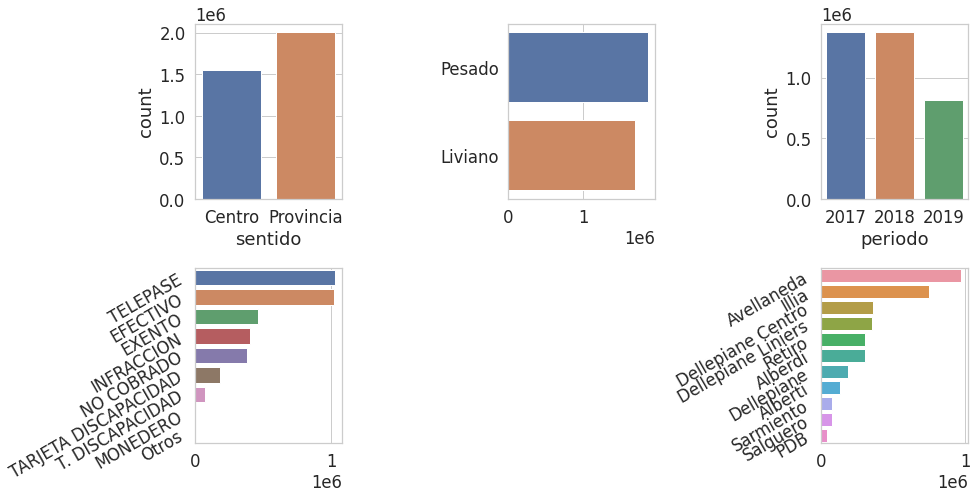

In [ ]:
data_2017 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto3/Datasets/flujo-vehicular-2017.csv', sep =',')

#Unimos los datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas. Sino se tiene que hacer este chequeo.
dataset = pd.concat([data_2019, data_2018,data_2017]) #concatena por fila y tendré un dataset desde el 2019 al 2017
#observo el dataset en general para indagar sus datos
plt.figure(figsize=(14,10))
plt.subplot(3,3,1)
sns.countplot(data = dataset, x = 'sentido')
plt.subplot(3,3,2)
a=(((dataset['tipo_vehiculo'].sort_values(ascending=True))).value_counts(ascending=False))
sns.barplot(x=a.values, y = a.index)
plt.subplot(3,3,3)
sns.countplot(data = dataset, x = 'periodo')
plt.subplot(3,3,4)
a=(((dataset['forma_pago'].sort_values(ascending=True))).value_counts(ascending=False))
sns.barplot(x=a.values, y = a.index)
plt.yticks(rotation=30)

plt.subplot(3,3,6)
a=(((dataset['estacion'].sort_values(ascending=True))).value_counts(ascending=False))
sns.barplot(x=a.values, y = a.index)
plt.yticks(rotation=30)
plt.tight_layout()

Realizando una observación del dataset incorporando el 2017. Se tiene que el flujo vehicular entre 2017 y 2018 fue cuasiconstante y en el 2019 disminuye notablemente.
El tráfico tuvo una mayoría de vehículos pesados, aportado más en los datos de 2017 y una mayor circulación hacia provincia. En cuanto a la forma de pago se mantuvo igual el pago por telepase y efectivo. Lo que si llama la atención es los exento, en infracción y no cobrado son otro punto clave a analizar dado que su numero es alto.


In [ ]:

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset1 = dataset[mask]


#Quitamos las columnas que no vamos a utilizar
dataset1.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)


#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset1['fecha2'] = pd.to_datetime(dataset1.fecha) + pd.to_timedelta(dataset1.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset1.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset1.rename(columns = {'fecha2':'fecha'}, inplace = True) 



#Reordenamos el dataset por fecha
dataset1.sort_values('fecha', inplace = True)
dataset1.reset_index(drop=True, inplace = True)

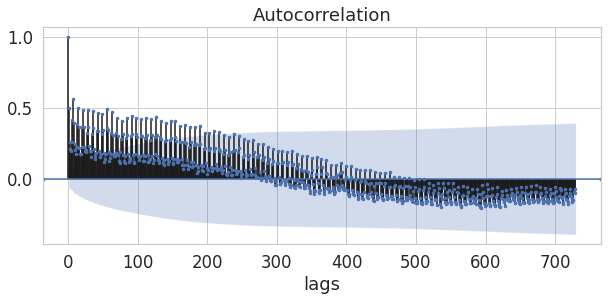

Observations: 1089
Training Observations: 850
Testing Observations: 92
Observations: 1089
Training Observations: 850
Testing Observations: 92


In [ ]:

# Resampleo diario, semanal y mensual del flujo vehicular
dataset_D = dataset1.resample('D', on='fecha').sum() #diario

result_adi = seasonal_decompose(dataset_D.cantidad_pasos, model='additive') #usa un modelo adaptativo por como se estudia la estacionanlidad


#analizo el autocorrelograma
nlags =  365*2
import matplotlib
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
matplotlib.rcParams['figure.figsize'] = [10,4]
plot_acf(dataset_D.cantidad_pasos, lags =np.arange(nlags),use_vlines=True,marker='.')
plt.xlabel('lags')
plt.savefig(path+'autocor1',facecolor='xkcd:white')
plt.show()


#Dado que me sugieren predecir el último trimestre del 2019, dichos datos serán mi conjunto test y los demás los train
#Modelaré la tendencia y la estacionalidad por separado por el análisis previo.
trend = result_adi.trend
wOut_trend = dataset_D.cantidad_pasos-trend





#train test split simple (para saber el porcentaje de observaciones train y test. luego procedo con un metodo de one step)
X_t = trend.dropna()
train_size = int(len(X_t) * 0.919) #<--- con la serie del 2017-2019 el train con el 0.919 de los datos deja al test con el último trimestre
train_trend, test_trend = X_t[0:train_size], X_t[train_size:len(X_t)]



X_wOt = wOut_trend.dropna()
train_size = int(len(X_wOt) * 0.919) #<--- con la serie del 2017-2019 el train con el 0.919 de los datos deja al test con el último trimestre
train_wOut_trend, test_wOut_trend = X_wOt[0:train_size], X_wOt[train_size:len(X_wOt)]


#se tiene Training Observations: 638 y Testing Observations: 92, este último considera el último trimestre.
#inicialmente considero un lookback de 10 días por la baja correlación en el autocorrelograma
look_back=100 #cuanto del inicio de la serie tomo datos para entrenar mis modelos. Cuanto mayor el look_back más datos del "presente" uso
N_train=950 #resto de dias de los dos años
N_test=92 #tres meses 
length_total_wOt,X_wOt_train,y_wOt_train,X_wOt_test,y_wOt_test,y_wOt= timeseriestraintest(X_wOt,look_back,N_train,N_test)
length_total_t,X_t_train,y_t_train,X_t_test,y_t_test,y_t= timeseriestraintest(X_t,look_back,N_train,N_test)




* Llama la atención el agregar el 2017 como aumenta la autocorellación a mayores lags (hasta 200) y con valores cercanos a 0.5, esto puede producir un impacto positivo para capturar mejor la serie con el tiempo.



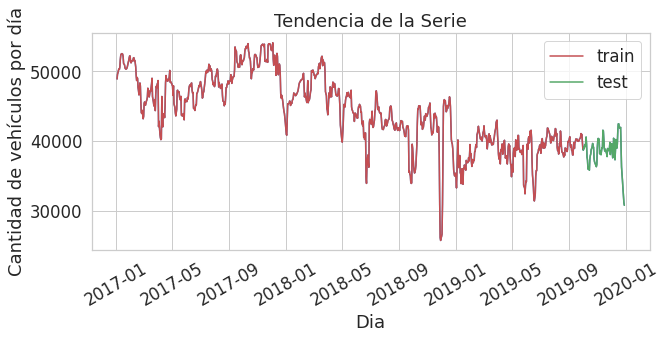

(array([736330., 736450., 736573., 736695., 736815., 736938., 737060.,
        737180., 737303., 737425.]),
 <a list of 10 Text major ticklabel objects>)

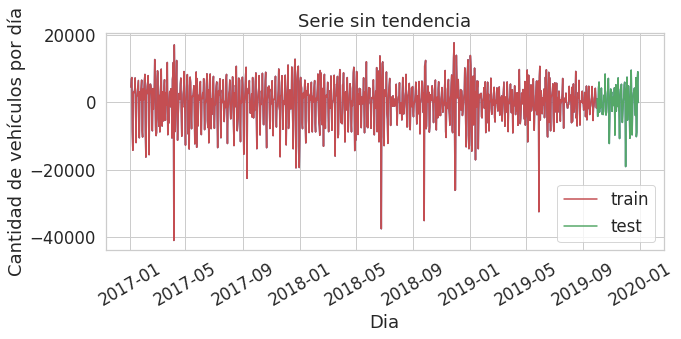

In [ ]:
plt.figure()
plt.plot(X_t)
plt.plot(train_trend,c='r',label='train')
plt.plot(test_trend,c='g',label='test')
plt.legend()
plt.xticks(rotation=30)
plt.title('Tendencia de la Serie')
plt.xlabel('Dia')
plt.ylabel('Cantidad de vehículos por día')

plt.savefig(path+'traintestTendencia',facecolor='xkcd:white')
plt.show()


plt.figure()
plt.plot(X_wOt)
plt.plot(train_wOut_trend,c='r',label='train')
plt.plot(test_wOut_trend,c='g',label='test')
plt.legend()
plt.xticks(rotation=30)
plt.title('Serie sin tendencia')
plt.ylabel('Cantidad de vehículos por día')
plt.xlabel('Dia')
plt.savefig(path+'traintestSinTendencia',facecolor='xkcd:white')

plt.xticks(rotation=30)

The best parameteres after RandomSearchCV {'n_estimators': 200, 'loss': 'square', 'learning_rate': 0.1}
The best estimator after RandomSearchCV AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='square',
                  n_estimators=200, random_state=None)
The best score RMSE after RandomSearchCV 1493.3250320815928
The best parameteres after RandomSearchCV {'n_estimators': 500, 'loss': 'exponential', 'learning_rate': 0.1}
The best estimator after RandomSearchCV AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='exponential',
                  n_estimators=500, random_state=None)
The best score RMSE after RandomSearchCV 4802.108683645817


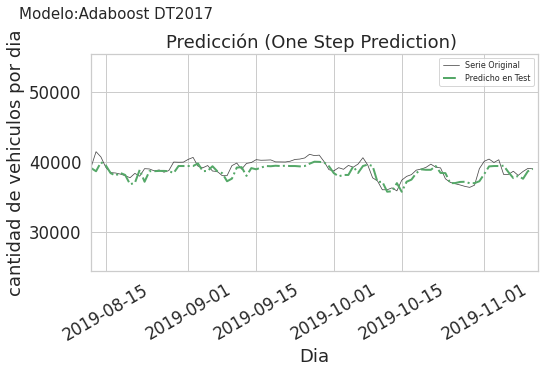

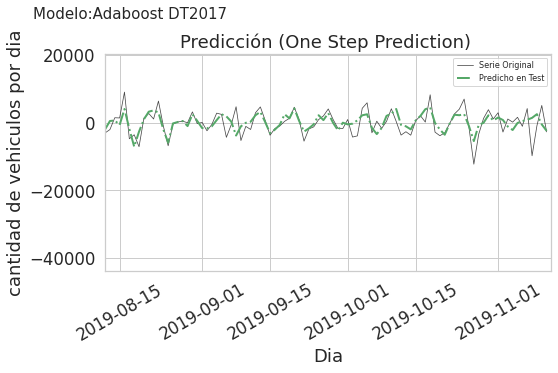

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(quantile_range=(25, 75))

#tendencia de la serie
X_t_train_sc= pd.DataFrame(scaler.fit_transform(X_t_train)) #es importante notar que al hacer el escalado lo que devuelve es un array, por lo que se vuelve a transformar en DataFrame para manipular los datos de forma más ordenada.
X_t_test_sc= pd.DataFrame(scaler.transform(X_t_test)) #son instancias que supongo que vendran despues y no los escalos.


#serie sin tendencia
X_wOt_train_sc= pd.DataFrame(scaler.fit_transform(X_wOt_train)) #es importante notar que al hacer el escalado lo que devuelve es un array, por lo que se vuelve a transformar en DataFrame para manipular los datos de forma más ordenada.
X_wOt_test_sc= pd.DataFrame(scaler.transform(X_wOt_test)) #son instancias que supongo que vendran despues y no los escalos.

Ada_t = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=100, random_state=42).fit(X_t_train_sc, y_t_train)
Ada_wOt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=100, random_state=42).fit(X_wOt_train_sc, y_wOt_train)


y_train_pred = Ada_t.predict(X_t_train_sc) #predicción con datos de entrenamiento
y_test_pred = Ada_t.predict(X_t_test_sc) #predicción con datos de testeo
plotSerie(X_t,N_train,N_test,look_back,length_total_t,y_train_pred,y_test_pred,'Adaboost DT2017')
S_ADA_t=MetricasSerie(y_t_train,y_t_test,y_train_pred,y_test_pred,'Adaboost DT')

y_train_pred = Ada_wOt.predict(X_wOt_train_sc) #predicción con datos de entrenamiento
y_test_pred = Ada_wOt.predict(X_wOt_test_sc) #predicción con datos de testeo
plotSerie(X_wOt,N_train,N_test,look_back,length_total_wOt,y_train_pred,y_test_pred,'Adaboost DT2017')
S_ADA=MetricasSerie(y_wOt_train,y_wOt_test,y_train_pred,y_test_pred,'Adaboost DT')


param_dist = {'n_estimators': [10,50,100,200,300,400,500,700,1000], 'learning_rate' : [0.001,0.005,0.01,0.05,0.1,0.5,1], 'loss' : ['linear', 'square', 'exponential']}
ADADT_RS_t=RandomizedSearchCV(AdaBoostRegressor(), param_distributions = param_dist, cv=5,  n_iter = 10, n_jobs=-1,scoring='neg_root_mean_squared_error').fit(X_t_train_sc,y_t_train)
print('The best parameteres after RandomSearchCV', ADADT_RS_t.best_params_)
print('The best estimator after RandomSearchCV',ADADT_RS_t.best_estimator_)
print('The best score RMSE after RandomSearchCV',-ADADT_RS_t.best_score_)

ADADT_RS_wOt=RandomizedSearchCV(AdaBoostRegressor(), param_distributions = param_dist, cv=5,  n_iter = 10, n_jobs=-1,scoring='neg_root_mean_squared_error').fit(X_wOt_train_sc,y_wOt_train)
print('The best parameteres after RandomSearchCV', ADADT_RS_wOt.best_params_)
print('The best estimator after RandomSearchCV',ADADT_RS_wOt.best_estimator_)
print('The best score RMSE after RandomSearchCV',-ADADT_RS_wOt.best_score_)



Aclaración: los bestparams que se colocan a las funciones a continuación fueron obtenidos con la optimización de hiperparámetros realizada cuando hice el análisis. Es probable que algun valor cambie porque no es un proceso exacto y la aleatoriedad puede influir en los cambios de parámetros. Es por esto que de aquí en más se usan los hiperparámetros encontrados en mi análisis.

Error RMSE en datos de train: 991.7022
Error RMSE en datos de test: 802.3643
Error (R2) en datos de train: 0.96393
Error (R2) en datos de test: 0.60002


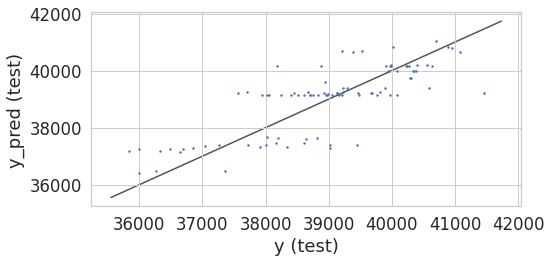

Error RMSE en datos de train: 3022.8556
Error RMSE en datos de test: 2793.903
Error (R2) en datos de train: 0.76164
Error (R2) en datos de test: 0.40241


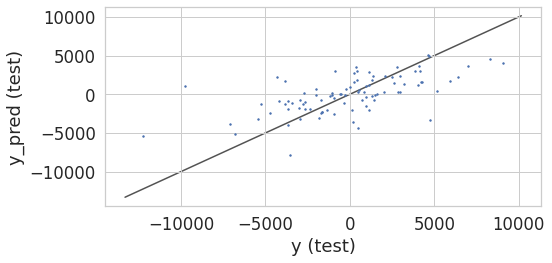

In [ ]:

Ada_t = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=50,learning_rate= 0.01,loss= 'exponential', random_state=42).fit(X_t_train_sc, y_t_train)
evaluar_model(Ada_t,X_t_train_sc, X_t_test_sc, y_t_train, y_t_test,modelo_a_evaluar='AdaBoostDT_t_2017')

Ada_wOt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=300, learning_rate= 0.5,loss= 'exponential',random_state=42).fit(X_wOt_train_sc, y_wOt_train)
evaluar_model(Ada_wOt,X_wOt_train_sc, X_wOt_test_sc, y_wOt_train, y_wOt_test,modelo_a_evaluar='AdaBoostDT_wot_2017')



Al incorporar el año 2017 se tuvo en términos generales que la performance en el test para el modelo optimizado una  mejora llamativa del rendimiento, a pesar de la desmejora en el train.
Esto puede deberse a que los datos más viejos ayudan a los más nuevos en la predicción debido a la repetición de ciclos de períodos largos, esto hizo que en la serie sin tendencia que mostrara la mayor mejora.  En este caso la reproducción de los picos o saltos es mejor representada (esto puede deberse a una mejor comprensión del modelo por los cambios gracias a tener mayor información).

En la tendencia se sigue observando el desfasaje entre la predicción y lo observado. Sin embargo la forma de la predicción es coherente. Aún así el error es elevado y hay que seguir mejorando.

Sin la tendencia.

    sin 2017:  RMSE train: 2929.528672    RMSE test: 3532.355442
    con 2017:  RMSE train: 3022.8556      RMSE test: 2793.903
La tendencia 


    sin 2017:  RMSE train:  736.784822   RMSE test: 971.511581
    con 2017:  RMSE train:  991.7022     RMSE test: 802.3643


Concluyendo: incorporar más datos en el tiempo puede mejorar la performance de los modelos debido a una mayor autocorrelación que pueden tener los datos de la serie. Especialmente para las series sin tendencia, donde la estacionalidad y los ciclos principales pueden generar mayor impacto en lo predicho. 


----------------------------
##**Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?**

In [ ]:
data_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proyecto3/Datasets/flujo-vehicular-2020.csv', sep =',')
print(data_2020.shape)
#ojo que estan distintos los nombres de estacion y forma_pago
data_2020['forma_pago'].unique()
data_2020['estacion'].unique()
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask]
print(data_2020.shape)


(2533743, 13)


(52374, 13)

In [ ]:
data_2020bis = data_2020[['dia','sentido','tipo_vehiculo','cantidad_pasos','fecha','periodo','forma_pago','estacion']]
data_2020bis.head()
print(data_2020bis.shape)

dia    sentido tipo_vehiculo  ...  periodo forma_pago  estacion
52   Miércoles     Centro          Auto  ...   2020.0   Efectivo     ILLIA
53   Miércoles  Provincia          Auto  ...   2020.0   Efectivo     ILLIA
134  Miércoles     Centro          Auto  ...   2020.0   Efectivo     ILLIA
135  Miércoles  Provincia          Auto  ...   2020.0   Efectivo     ILLIA
202  Miércoles     Centro          Auto  ...   2020.0   Efectivo     ILLIA

[5 rows x 8 columns]

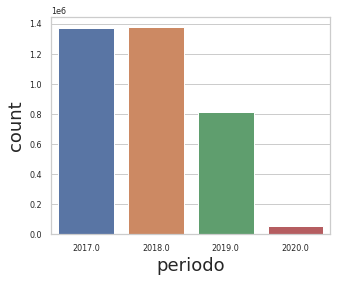

In [ ]:

#Unimos los datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas. Sino se tiene que hacer este chequeo.
dataset2 = pd.concat([data_2020bis,dataset1[::-1]]) #concatena por fila y tendré un dataset desde el 2020 al 2017
#observo el dataset en general para indagar sus datos
plt.figure(figsize=(5,4))
sns.countplot(data = dataset, x = 'periodo')

dataset2=dataset2[['dia', 	'sentido', 	'tipo_vehiculo', 	'cantidad_pasos', 	'fecha']]
dataset2['fecha'] = pd.to_datetime(dataset2['fecha'])

En este caso particular el flujo vehicular durante 2020 tuvo un desplome significativo debido al impacto de la cuarentena como medida de "prevencion" de la pandemia del COVID 19.
En este caso no es un cambio propio de la serie por medidas de reducción de tránsito privado a público o cambios en las tarifas (como venían haciendose en los años previos), sino que fue por un cambio externo al problema.
Esto puede impactar en los modelos significativamente y se espera que las predicciones fallen porque la experiencia del pasado no es igual a la presente (2020).

In [ ]:

# Resampleo diario, semanal y mensual del flujo vehicular
dataset_D = dataset2.resample('D', on='fecha').sum() #diario

result_adi = seasonal_decompose(dataset_D.cantidad_pasos, model='additive') #usa un modelo adaptativo por como se estudia la estacionanlidad


#Dado que me sugieren predecir el último trimestre del 2019, dichos datos serán mi conjunto test y los demás los train
#Modelaré la tendencia y la estacionalidad por separado por el análisis previo.
trend = result_adi.trend
wOut_trend = dataset_D.cantidad_pasos-trend


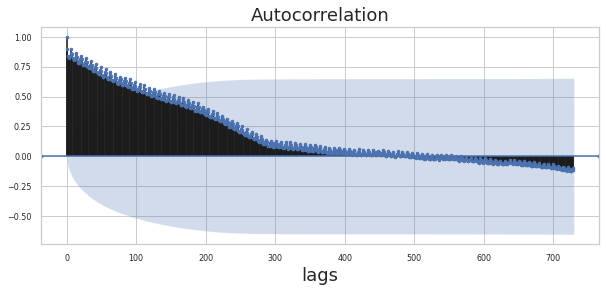

Observations: 1455
Training Observations: 990
Testing Observations: 364
Observations: 1455
Training Observations: 990
Testing Observations: 364


In [ ]:
#analizo el autocorrelograma
nlags =  365*2
import matplotlib
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
matplotlib.rcParams['figure.figsize'] = [10,4]
plot_acf(dataset_D.cantidad_pasos, lags =np.arange(nlags),use_vlines=True,marker='.')
plt.xlabel('lags')
plt.savefig(path+'autocor1',facecolor='xkcd:white')
plt.show()


#train test split simple (para saber el porcentaje de observaciones train y test. luego procedo con un metodo de one step)
X_t = trend.dropna()
train_size = int(len(X_t) * 0.75) #<--- con la serie del 2017-2019 el train con el  0.75 de los datos deja al test con el 2020
test_size=1-int(len(X_t) * 0.75) 
train_trend, test_trend = X_t[0:train_size], X_t[train_size:len(X_t)]



X_wOt = wOut_trend.dropna()
train_size = int(len(X_wOt) * 0.75) #<--- con la serie del 2017-2019 el train con el  0.75 de los datos deja al test con el 2020
train_wOut_trend, test_wOut_trend = X_wOt[0:train_size], X_wOt[train_size:len(X_wOt)]


#se tiene Training Observations: 638 y Testing Observations: 92, este último considera el último trimestre.
#inicialmente considero un lookback de 10 días por la baja correlación en el autocorrelograma
look_back=100 #cuanto del inicio de la serie tomo datos para entrenar mis modelos. Cuanto mayor el look_back más datos del "presente" uso
N_train=1090 #resto de dias de los dos años
N_test=364 #tres meses 
length_total_wOt,X_wOt_train,y_wOt_train,X_wOt_test,y_wOt_test,y_wOt= timeseriestraintest(X_wOt,look_back,N_train,N_test)
length_total_t,X_t_train,y_t_train,X_t_test,y_t_test,y_t= timeseriestraintest(X_t,look_back,N_train,N_test)



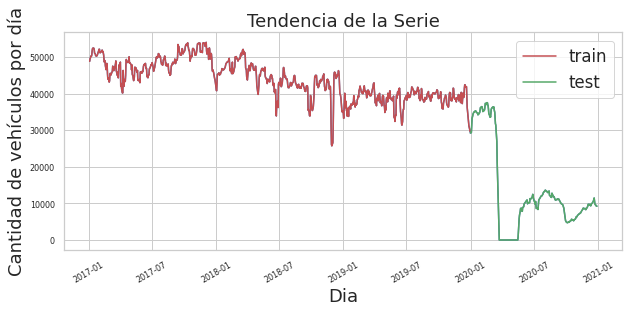

(array([736330., 736511., 736695., 736876., 737060., 737241., 737425.,
        737607., 737791.]), <a list of 9 Text major ticklabel objects>)

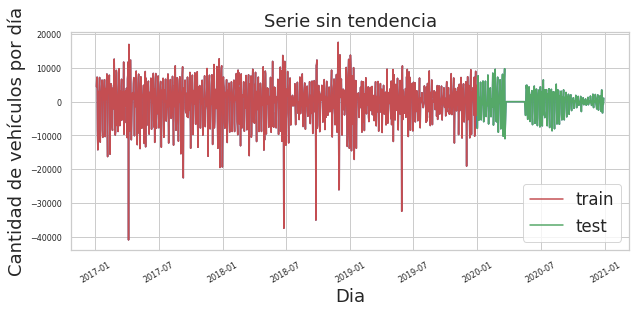

In [ ]:
plt.figure()
plt.plot(X_t)
plt.plot(train_trend,c='r',label='train')
plt.plot(test_trend,c='g',label='test')
plt.legend()
plt.xticks(rotation=30)
plt.title('Tendencia de la Serie')
plt.xlabel('Dia')
plt.ylabel('Cantidad de vehículos por día')

plt.savefig(path+'traintestTendencia',facecolor='xkcd:white')
plt.show()


plt.figure()
plt.plot(X_wOt)
plt.plot(train_wOut_trend,c='r',label='train')
plt.plot(test_wOut_trend,c='g',label='test')
plt.legend()
plt.xticks(rotation=30)
plt.title('Serie sin tendencia')
plt.ylabel('Cantidad de vehículos por día')
plt.xlabel('Dia')
plt.savefig(path+'traintestSinTendencia',facecolor='xkcd:white')

plt.xticks(rotation=30)

The best parameteres after RandomSearchCV {'n_estimators': 400, 'loss': 'exponential', 'learning_rate': 0.01}
The best estimator after RandomSearchCV AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='exponential',
                  n_estimators=400, random_state=None)
The best score RMSE after RandomSearchCV 1381.9669396026197
The best parameteres after RandomSearchCV {'n_estimators': 50, 'loss': 'exponential', 'learning_rate': 0.5}
The best estimator after RandomSearchCV AdaBoostRegressor(base_estimator=None, learning_rate=0.5, loss='exponential',
                  n_estimators=50, random_state=None)
The best score RMSE after RandomSearchCV 4598.733961393741


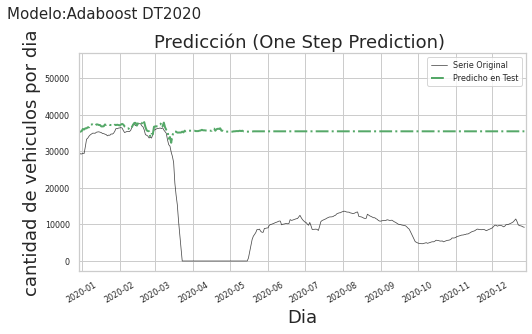

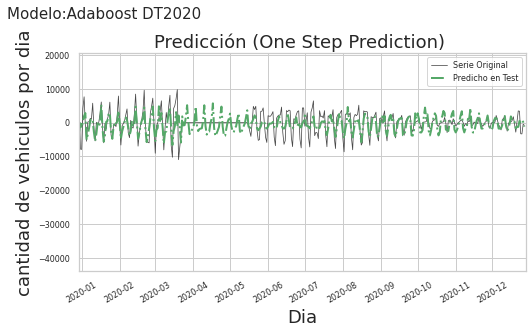

In [ ]:

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(quantile_range=(25, 75))

#tendencia de la serie
X_t_train_sc= pd.DataFrame(scaler.fit_transform(X_t_train)) #es importante notar que al hacer el escalado lo que devuelve es un array, por lo que se vuelve a transformar en DataFrame para manipular los datos de forma más ordenada.
X_t_test_sc= pd.DataFrame(scaler.transform(X_t_test)) #son instancias que supongo que vendran despues y no los escalos.


#serie sin tendencia
X_wOt_train_sc= pd.DataFrame(scaler.fit_transform(X_wOt_train)) #es importante notar que al hacer el escalado lo que devuelve es un array, por lo que se vuelve a transformar en DataFrame para manipular los datos de forma más ordenada.
X_wOt_test_sc= pd.DataFrame(scaler.transform(X_wOt_test)) #son instancias que supongo que vendran despues y no los escalos.

Ada_t = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=100, random_state=42).fit(X_t_train_sc, y_t_train)
Ada_wOt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=100, random_state=42).fit(X_wOt_train_sc, y_wOt_train)


y_train_pred = Ada_t.predict(X_t_train_sc) #predicción con datos de entrenamiento
y_test_pred = Ada_t.predict(X_t_test_sc) #predicción con datos de testeo
plotSerie(X_t,N_train,N_test,look_back,length_total_t,y_train_pred,y_test_pred,'Adaboost DT2020')
S_ADA_t=MetricasSerie(y_t_train,y_t_test,y_train_pred,y_test_pred,'Adaboost DT')

y_train_pred = Ada_wOt.predict(X_wOt_train_sc) #predicción con datos de entrenamiento
y_test_pred = Ada_wOt.predict(X_wOt_test_sc) #predicción con datos de testeo
plotSerie(X_wOt,N_train,N_test,look_back,length_total_wOt,y_train_pred,y_test_pred,'Adaboost DT2020')
S_ADA=MetricasSerie(y_wOt_train,y_wOt_test,y_train_pred,y_test_pred,'Adaboost DT')


param_dist = {'n_estimators': [10,50,100,200,300,400,500,700,1000], 'learning_rate' : [0.001,0.005,0.01,0.05,0.1,0.5,1], 'loss' : ['linear', 'square', 'exponential']}
ADADT_RS_t=RandomizedSearchCV(AdaBoostRegressor(), param_distributions = param_dist, cv=5,  n_iter = 10, n_jobs=-1,scoring='neg_root_mean_squared_error').fit(X_t_train_sc,y_t_train)
print('The best parameteres after RandomSearchCV', ADADT_RS_t.best_params_)
print('The best estimator after RandomSearchCV',ADADT_RS_t.best_estimator_)
print('The best score RMSE after RandomSearchCV',-ADADT_RS_t.best_score_)

ADADT_RS_wOt=RandomizedSearchCV(AdaBoostRegressor(), param_distributions = param_dist, cv=5,  n_iter = 10, n_jobs=-1,scoring='neg_root_mean_squared_error').fit(X_wOt_train_sc,y_wOt_train)
print('The best parameteres after RandomSearchCV', ADADT_RS_wOt.best_params_)
print('The best estimator after RandomSearchCV',ADADT_RS_wOt.best_estimator_)
print('The best score RMSE after RandomSearchCV',-ADADT_RS_wOt.best_score_)



Error RMSE en datos de train: 938.2143
Error RMSE en datos de test: 21825.1602
Error (R2) en datos de train: 0.96778
Error (R2) en datos de test: -2.4228


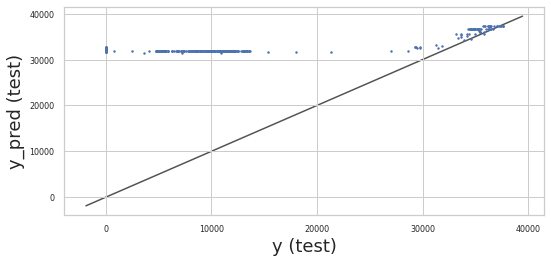

Error RMSE en datos de train: 3183.8145
Error RMSE en datos de test: 2586.1338
Error (R2) en datos de train: 0.71665
Error (R2) en datos de test: 0.37073


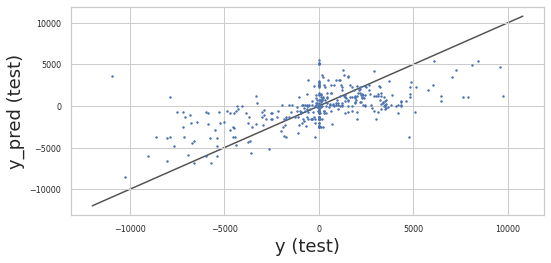

In [ ]:
Ada_t = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=400,learning_rate= 0.01,loss= 'exponential', random_state=42).fit(X_t_train_sc, y_t_train)
evaluar_model(Ada_t,X_t_train_sc, X_t_test_sc, y_t_train, y_t_test,modelo_a_evaluar='AdaBoostDT_t_2017')

Ada_wOt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=50, learning_rate= 0.5,loss= 'exponential',random_state=42).fit(X_wOt_train_sc, y_wOt_train)
evaluar_model(Ada_wOt,X_wOt_train_sc, X_wOt_test_sc, y_wOt_train, y_wOt_test,modelo_a_evaluar='AdaBoostDT_wot_2017')


Como se espera que el cambio natural afecte, la predicción de la tendencia fue el que dio los peores resultados dado que el modelo no tenía experiencias previas en los datos del cambio abrupto que generó el paro total del flujo vehicular durante la cuarentena estricta. Aún así en los momentos de recuperación del flujo el modelo sólo atinó a dar un valor constante en el tiempo por su imposibilidad de ver más allá. En ese sentido es bueno que los modelos tengan pesos de penalidades para mejorar las predicciones futuras, ya que el modelo sobreestimó toda observación.

Lo que sí llama la atención fue la respuesta del modelo a la serie sin tendencia, que si bien no mostró un buen rendimiento por el impacto producido por un factor externo, sí capturó algunos ciclos que posibilitaron predecir (al igual que antes, sobreestimacion en valores bajos y subestimación en los altos).

    -Tendencia 2020
    Error RMSE en datos de train: 938.2143
    Error RMSE en datos de test: 21825.1602 **--> se nota un error abismal**

    -Serie sin tendencia 2020
    Error RMSE en datos de train: 3183.8145
    Error RMSE en datos de test: 2586.1338


Resumiendo los efectos de impactos externos, cortes totales, desvíos, recirculación, embotellamientos, corte por reparación, parate total por efectos externos, generan que los modelos sin aprendizaje previo de los datos con alguna experiencia similar no logren capturar la naturaleza del efecto. Esto se evidencia al contrastar la prediccion del 2020 y fines 2019 con datos del 2017-2019 que mostraron dos casos, el primero extremo y el segundo con experiencias que también se generaron en otros años. Apartir de esto se concluye que para estudiar las series temporales es importante contar con la mayor cantidad de información en lo que respecta a cambios abruptos, saltos o cambios en la naturaleza de la serie ya que de ello depende la predicción.

----------
-----------------

# Parte C- Investigacion 


El objetivo de esta sección es que sugieras cómo continuarías el proyecto, con el fin de mejorar el modelo o responder una pregunta que consideres interesante. En todos los notebooks dejamos algunas sugerencias, pero puedes proponer otras.


  *   Debes explicar qué te gustaría probar, por qué y cómo lo harías. 

*   Si tienes referencias (por ejemplo, un artículo que hayas encontrado, capítulo de libro, etc.), debes mencionarlas.
*    Debes comentar también qué resultados esperas encontrar. Por ejemplo, puedes implementar una prueba rápida y mostrar resultados preliminares, para ver si estás correctamente orientado.






Como trabajo a futuro me gustaría seguir indagando en las predicciones de series de tiempo que es donde se tiene el mayor desafío. En este sentido me  interesaría analizar los modelos estadísticos clásicos (AR, MA, ARIMA, etc), los cuales tienen más robustez en estos temas y es probable que permitan capturar mejor las distinas componentes de la serie para estimar las predicciones. En ese sentido utilizaría la librería de statmodel que presenta python, donde ya cuenta con estos modelos predictores y se realizará un preliminar de los resultados.

Uno espera que estos modelos logren mejorar las predicciones incluso en casos extremos como el del 2020 donde los modelos de ML presentan mayor dificultad.

Bibliografía:

    [Arima_book](https://people.duke.edu/~rnau/411arim.htm)
    [Arima_book2](https://bookdown.org/content/2274/series-temporales.html)
    [Arima_intro](https://towardsdatascience.com/an-introduction-to-time-series-analysis-with-arima-a8b9c9a961fb)
    [Arima_intro2](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
    [Arima_stats](https://towardsdatascience.com/understanding-arima-time-series-modeling-d99cd11be3f8)
    [Python_ARima](https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)
    [Python_ARima2](https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051)



#De las clases de acámicas se tiene como contexto teórico de los Modelos clásicos 

Existen tres modelos (o procesos) que fueron durante mucho tiempo el “estado del arte” en series de tiempo. Por lo que es importante conocer sus principales características. 
    Procesos Autoregresivos (AR)
    Procesos de Media Móvil (MA)
    Procesos ARMA y ARIMA, que son una combinación de los dos primeros

1.Procesos Autorregresivos AR(p)

Son procesos en los que el valor de Y observado en el tiempo t depende de sus p valores anteriores (t-1, t-2, …, t-p).

Es decir que podría expresarse [EC.1](https://sc.acamica.com/content/toolbox/ds/ds_42_a.png
)

Podríamos entender estos procesos como el grado en que el valor de hoy depende del mismo valor, pero del pasado. El valor de alpha representa el componente independiente de nuestro valor en t, mientras que los valores de beta corresponden a cuánto peso le otorgamos a nuestros valores pasados para componer el valor al momento t. Como siempre, incluímos a epsilon como el término de error de medición de nuestro proceso. Dentro de las componentes mencionadas en la bitácora anterior, este término se corresponde con el ruido blanco.

    Procesos de media móvil MA(q)

Los procesos de media móvil se conforman como una combinación de variables aleatorias no correlacionadas (ruido blanco), que son ni más ni menos que los términos de error: [EC.2](https://sc.acamica.com/content/toolbox/ds/ds_42_b.png)

Así como en los procesos autoregresivos miramos los valores del pasado y los ponderamos, en los procesos de media móvil buscamos incluir en nuestro valor en el momento t los distintos valores de ruido blanco que existieron a lo largo del tiempo.

    Procesos ARMA y ARIMA

Tenemos entonces dos modelos: AR, que ve los valores del pasado y los pondera, y MA, que incluye los procesos de ruido blanco.

La suma de estos dos modelos se expresa como ARMA(p, q). Está compuesto por una combinación lineal de los valores pasados junto con los términos de error, ambos ponderados, para explicar el valor de nuestra variable en el momento t.

En la bitácora anterior mencionamos el concepto de “procesos no estacionarios” como aquellos que tienen tendencia no nula. Para trabajar mejor con estos modelos, es importante generar alguna modificación a nuestra serie para lograr que sea estacionaria (podemos pensar en esto como una normalización).

Cuando el proceso no es estacionario, diferenciamos la serie. Es decir, creamos una nueva variable:

Zt = Yt - Yt-1

El objetivo de esta diferenciación es disminuir el efecto de la tendencia en la serie. Al trabajar con esta nueva variable Zt, y reemplazando nuestros valores de Yt, Yt-1, etc., por sus respectivos procesos ARMA, obtenemos nuestro modelo ARIMA (p, q, d).

Este proceso es el más comúnmente utilizado en la estadística clásica, así que vamos a detenernos un poco a observar cómo se compone:

    Por un lado tenemos nuestro proceso AR(p) cómo una regresión lineal de los p valores anteriores a t.
    Por otro lado, tenemos nuestro proceso MA(q) como una regresión lineal de los q términos de error anteriores a t
    Por último, tenemos la resta de estos dos mismos componentes, pero calculados para Yt-d, con el objetivo de diferenciar nuestra serie y volverla estacionaria.


**Observación:** dado que son modelos estadísticos el costo computacional muchas veces es elevado y para ello la elección de los parámetros es importante.
En este caso se usarán parámetros replicando algunos vistos en notas, pero habria que seguir profundizando en eso.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(dataset2.cantidad_pasos, order=(5,1,0))
model_fit = model.fit()



In [ ]:
# summary of fit model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.cantidad_pasos   No. Observations:               291242
Model:                 ARIMA(5, 1, 0)   Log Likelihood            -2142757.163
Method:                       css-mle   S.D. of innovations            379.315
Date:                Fri, 19 Mar 2021   AIC                        4285528.327
Time:                        02:18:55   BIC                        4285602.400
Sample:                             1   HQIC                       4285549.778
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0011      0.181     -0.006      0.995      -0.357       0.354
ar.L1.D.cantidad_pasos    -0.9418      0.002   -519.128      0.000      -0.945      -0.938
ar.L

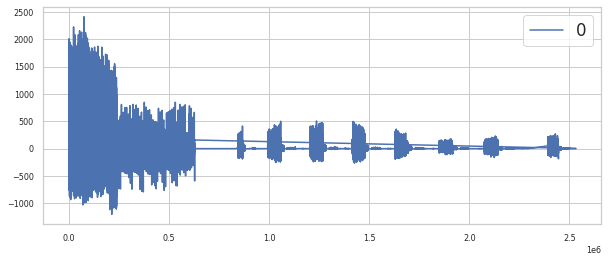

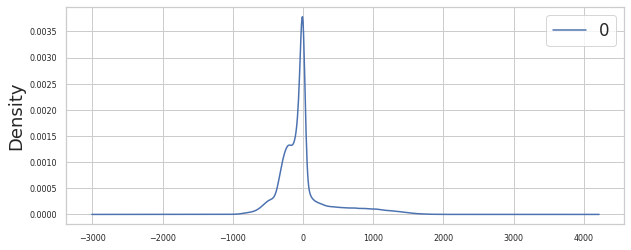

                   0
count  291242.000000
mean        0.001937
std       379.315899
min     -1202.781468
25%      -201.595589
50%       -38.575858
75%         6.432985
max      2409.761610


In [ ]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

# split into train and test sets
X = dataset2.cantidad_pasos
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [ ]:
# walk-forward validation
for t in range(round(len(test)/15000)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


predicted=10.344799, expected=1.000000
predicted=10.684444, expected=9.000000
predicted=10.939029, expected=644.000000
predicted=14.791578, expected=6.000000
predicted=158.665371, expected=1.000000
predicted=97.372423, expected=2.000000
predicted=131.433548, expected=23.000000


In [ ]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(history[0:len(predictions)], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 183.213


Como resultado preliminar se tiene que el modelo estadístico 
muestra valores bajos de error. Sin embargo, el costo computacional es grande. Es probable que para realizar una predicción a largo tiempo se demande mucho cómputo.

Otra posible idea es probar [Prophet](https://facebook.github.io/prophet/docs/quick_start.html),[Prophet_intro](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/), [GIT prophet](https://github.com/facebook/prophet/tree/master/examples)de Facebook para predecir series temporales, pero no se extenderá mucho más, sólo se procesará una idea. Se observa que la predicción debe mejorarse respecto a lo que se observa (y), pero tiene potencial

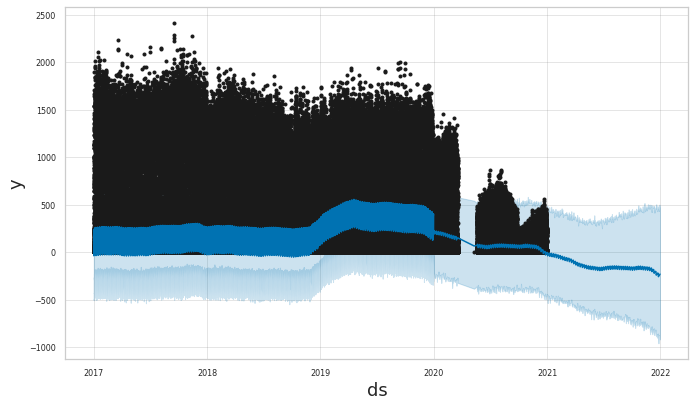

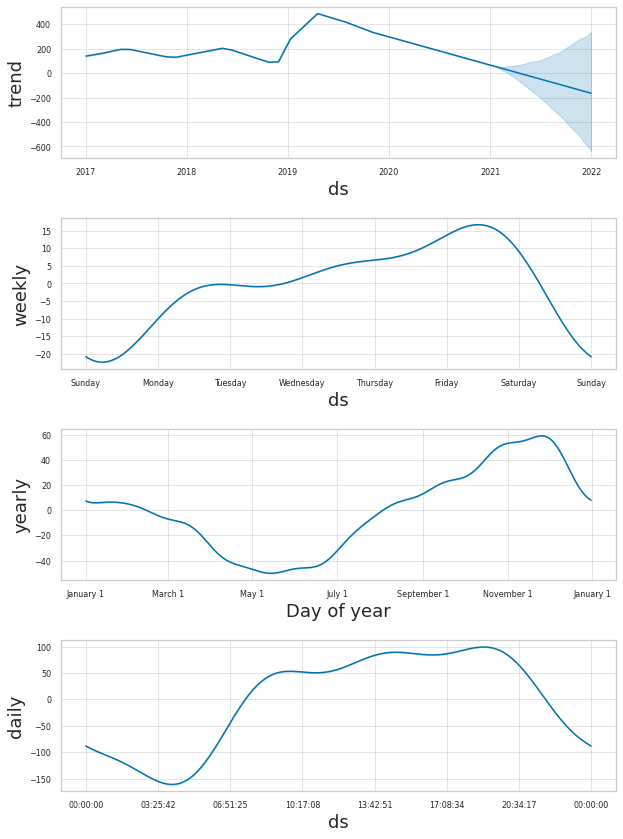

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
m = Prophet()

df_new = dataset2.rename(columns={'fecha': 'ds','cantidad_pasos':'y'})

m.fit(df_new)
future = m.make_future_dataframe(periods=365)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)



## Para pensar, investigar y, opcionalmente, implementar
* ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?

Una de las formas para incorporar tipo de vehículo (considerando que sólo se tiene vehículo pesado y liviano, se aclara porque en los datos de 2020 no estan clasificados así) y sentido se encodearía como binario (uno o cero).
Para las formas de pago como hay varias, sería con un One Hot Encoder haciendo una matriz de 0 y 1 para las diferentes variables.

Los días de la semana, como se observó influencia mayor en algunos días, se podría encodear de forma ordinal para darle peso a algunos días.

Es probable que pueda mejorarse la predicción incorporando las variable de los días. En lo que respecta a las otras variables habría que ver cómo estudiar la serie, ya que si se estudia como un conjunto talvez los valores de sentido de circulación puedan afectar, mas el tipo de pago habría que considerar un dataset más amplio donde se incorpore esos datos y ver la correlación cruzada entre los distintos medios de pago si eso influencia o no.

*   ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?

Cada autopista y peaje tiene su ritmo vehicular particular y comportamientos que se alteran dependiendo las epocas del año. Las que "miran" hacia el sur de Buenos Aires presentan más flujo en las épocas de recesos o feriados hacia la costa de la provincia más activo que los peajes del oeste o norte. Sin embargo, las autopistas que presentan cercanía con la Illia y su peaje pueden influenciar el flujo vehicular de dicho peaje por motivos de cortes o desvíos previo a llegar al mismo debido a circunstancias ocacionadas en las demás arterias vehiculares.
Esta hipótesis puede ayudar a incorporar información extra como un factor de peso o "penalidad" a las series para proyectar a futuro posiles efectos entre autopistas.

En este caso se realizan supuestos ya que se encesita un estudio más profundo estadístico sobre las distintas autopistas y su relación. Estos temas no fueron abordados en el curso y necesita mayor tiempo de estudio y por ello considero que no indagaré esto.



**Observación:** se encontró luego del estudio completo que dentro del registro general habían datos duplicados. Esto pudo haber incidido en los modelos y las predicciones por lo que otra cosa a mejorar es en el preprocesamiento mejorar la limpieza de datos que en este caso no fue completa ya que los datos parecían prolijos (MEA CULPA)

El dataset original (2017-2020) cuenta un total de datos (fila,columna) de:  (3613080, 10) y cuenta un total de datos duplicados en (fila,columna) de:  (155874, 10)

**Observación:** Queda pendiente realizar modificaciones en el lookback para ver si hay mejora o no de las metricas. Sumado a eso, dado que en el curso la cross validation en series de tiempo no se pudo realizar con los procesos que se vieron, por lo que resta ver el impacto del  [Timeseriessplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html),[TSCV](https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8) ,[TimeserieCV](https://pubs.acs.org/doi/10.1021/ci400084k) 

In [ ]:
print('El dataset original cuenta un total de datos (fila,columna) de: ',dataset2.shape)
print('El dataset original cuenta un total de datos duplicados en (fila,columna) de: ',dataset2[dataset2.duplicated()].shape)
#Datos_prop=Datos_prop.drop_duplicates()


El dataset original cuenta un total de datos (fila,columna) de:  (3613080, 10)
El dataset original cuenta un total de datos duplicados en (fila,columna) de:  (155874, 10)
